# **Generative-AI-RAG-app: Friday**
#### **Elevating Customer Support with AI-driven RAG application**



**The main objective of this application is to develop an interactive, retrieval-augmented application designed to provide generalized responses to queries, based on historical chat interactions between the user and the agent.**

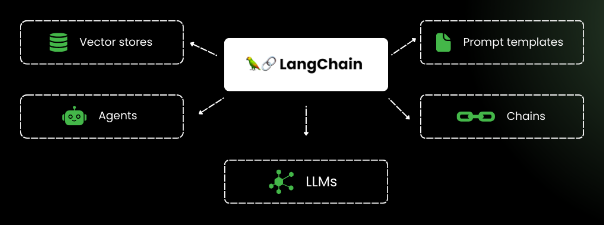



In [ ]:
### Connecting with google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
os.environ['ASSESSMENT_CSV_PATH'] = '/content/drive/MyDrive/LLM_RAG_application/customer_care/support_chat.csv'

### ⚙️ **Install dependencies**

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117 --upgrade
!pip install langchain einops accelerate transformers bitsandbytes scipy
!pip install xformers sentencepiece
!pip -q install chromadb
!pip install sentence-transformers
!pip install langchain-community

Looking in indexes: https://download.pytorch.org/whl/cu117
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 697.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 95.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 23.9 MB/s eta 0:00:00
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89987 sha256=8bc46c5cb467919f3eb49486c7a67959dfb6b3a5858704b3b9f731308e480474
  Stored in directory: /root/.cache/pip/wheels/27/2c/b6/3ed2983b1

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,pipeline
from transformers import BitsAndBytesConfig
from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
import torch

In [ ]:
from huggingface_hub import login
import json
with open('/content/drive/MyDrive/LLM_RAG_application/customer_care/token.json') as f:
    key  = json.load(f)
login(token=key["llm_token"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# Import necessary libraries for Preprocessing the data.

import json
import ast
import re
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
# Adjust pandas settings to display full column content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# ⏳📊 Loading Data & EDA:
We will load the dataset and perform an initial inspection to understand its structure and contents

In [ ]:

# Get the file path from the environment variable
file_path = os.getenv('ASSESSMENT_CSV_PATH')

# Check if the environment variable is set and the file path is valid
if file_path:
    print("File path retrieved from environment variable:", file_path)
else:
    print("Environment variable ASSESSMENT_CSV_PATH is not set.")

# Load the dataset
data = pd.read_csv(file_path)

#Shape of the dataframe
print(f'No. of rows in data = {data.shape[0]}\nNo. of columns in data = {data.shape[1]}\n\n\n')

# Preview the data
data.head()


File path retrieved from environment variable: /content/drive/MyDrive/LLM_RAG_application/customer_care/support_chat.csv
No. of rows in data = 4092
No. of columns in data = 64





,_class,_id,_index,_score,_type,annotations,aspects,client,comment,comments,dataSource,dataSourceType,datetime,externalId,index,metadata.account_modification_reasons,metadata.agent_return_reason,metadata.cancel_reasons,metadata.channel,metadata.customer_agrees_that_they_are_providing_this_information_voluntarily?,metadata.escalate,metadata.feedback_reasons,metadata.first_resolution_time_in_minutes_business,metadata.first_resolution_time_in_minutes_calendar,metadata.full_resolution_time_in_minutes_business,metadata.full_resolution_time_in_minutes_calendar,metadata.group_name,metadata.has_adverse_event,metadata.has_quality_complaint,metadata.is_campaign,metadata.lang,metadata.later_shipment_reasons,metadata.no_stella,metadata.offers_accepted,metadata.order_issue_reasons,metadata.organization_details,metadata.organization_notes,metadata.proactive_campaign?,metadata.product_question_reasons,metadata.promo_reasons,metadata.replies,metadata.reply_time_in_minutes_business,metadata.reply_time_in_minutes_calendar,metadata.requesterId,metadata.requester_wait_time_in_minutes_business,metadata.requester_wait_time_in_minutes_calendar,metadata.returns_reasons,metadata.rma_has_error,metadata.satisfactionRating,metadata.self-service_complaint,metadata.solved_at,metadata.status,metadata.subscription_modification_reasons,metadata.subscription_type_,metadata.technical_issue_reasons,metadata.text_reasons,metadata.ticket_has_return,metadata.time_spent_last_update_(sec),metadata.total_time_spent_(sec),metadata.website_inquiry_reasons,sentiment,solvedAt,source,title
0,com.sentisum.dp.esgateway.service.dto.EnrichedCustomerMessage,1588411,demo-nutrafol-support,NaN,_doc,"[{""theme"":"""",""topic"":""missing item"",""topicAspects"":[""refill joshua lili"",""order today""],""sentiment"":2}]","[""refill joshua lili"",""order today""]",demo-nutrafol,Hi I received my order today and only received a two month supply that included a bottle with a bag of refill Joshua Lili,"[{""createdAt"":""2023-06-21T07:04:09Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hi I received my order today and only received a two month supply that included a bottle with a bag of refill Joshua Lili""}]",zendesk,support,"Jun 21, 2023 @ 07:04:09.000",1588411,batchIndex,NaN,NaN,NaN,email,NaN,False,NaN,0,0,0,0,NaN,NaN,NaN,NaN,en,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,0.0,0,0,17779447520275,0,0,NaN,False,unoffered,False,NaN,new,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,2,NaN,demo-nutrafol-support,default
1,com.sentisum.dp.esgateway.service.dto.EnrichedCustomerMessage,1588410,demo-nutrafol-support,NaN,_doc,"[{""theme"":"""",""topic"":""support responsiveness"",""topicAspects"":[""provided star rating"",""comment terrible customer"",""awful original ticket""],""sentiment"":1},{""theme"":"""",""topic"":""customer support feedback"",""topicAspects"":[""provided star rating"",""comment terrible customer"",""awful original ticket""],""sentiment"":1}]","[""provided star rating"",""comment terrible customer"",""awful original ticket""]",demo-nutrafol,Please follow up with the customer about the feedback they provided Star rating 1 Comment Terrible customer service I would not be going out of my way to leave this message if it was not that awful Original ticket [REDACTED],"[{""createdAt"":""2023-06-21T06:46:43Z"",""authorType"":""Visitor"",""index"":0,""body"":""Please follow up with the customer about the feedback they provided Star rating 1 Comment Terrible customer service I would not be going out of my way to leave this message if it was not that awful Original ticket [REDACTED]""},{""createdAt"":""2023-06-21T15:53:02Z"",""authorType"":""Agent"",""index"":1,""body"":""This request was closed and merged into request #1566318 \""New ticket from dacquaah21@gmail...\"".""}]",zendesk,support,"Jun 21, 2023 @ 06:46:43.000",1588410,batchIndex,NaN,agent_return_reason_unaware_of_sub,cancel_accidental_sub,api,NaN,False,NaN,0,0,0,0,NaN,NaN,NaN,NaN,en,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,0.0,0,0,171946

In [ ]:
# Get summary information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092 entries, 0 to 4091
Data columns (total 64 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   _class                                                                          4092 non-null   object 
 1   _id                                                                             4092 non-null   int64  
 2   _index                                                                          4092 non-null   object 
 3   _score                                                                          0 non-null      float64
 4   _type                                                                           4092 non-null   object 
 5   annotations                                                                     4092 non-null   object 
 6   aspects         

### 🔍 Observations:
#### General Information:
- **Number of Entries**: 4092
- **Number of Columns**: 64
- **Data Types**:
  - Object (String): 54 columns
  - Float64: 6 columns
  - Int64: 4 columns

#### Key Points:
1. **Non-Null Columns**:
   - Columns like `_class`, `_id`, `_index`, `_type`, `annotations`, `aspects`, `client`, `comment`, `comments`, `dataSource`, `dataSourceType`, `externalId`, `index`, `metadata.channel`, `metadata.lang`, `metadata.requesterId`, `metadata.satisfactionRating`, `metadata.status`, `sentiment`, `source`, and `title` have 4092 non-null values, indicating no missing data in these columns.
   
2. **Columns with Significant Missing Values**:
   - Some columns have a high number of missing values, such as `_score` (all values are missing), `metadata.account_modification_reasons`, `metadata.customer_agrees_that_they_are_providing_this_information_voluntarily?`, `metadata.feedback_reasons`, `metadata.first_resolution_time_in_minutes_business`, `metadata.first_resolution_time_in_minutes_calendar`, `metadata.full_resolution_time_in_minutes_business`, `metadata.full_resolution_time_in_minutes_calendar`, `metadata.group_name`, `metadata.has_adverse_event`, `metadata.has_quality_complaint`, `metadata.is_campaign`, `metadata.later_shipment_reasons`, `metadata.no_stella`, `metadata.offers_accepted`, `metadata.order_issue_reasons`, `metadata.organization_details`, `metadata.organization_notes`, `metadata.proactive_campaign?`, `metadata.product_question_reasons`, `metadata.promo_reasons`, `metadata.replies`, `metadata.reply_time_in_minutes_business`, `metadata.reply_time_in_minutes_calendar`, `metadata.requester_wait_time_in_minutes_business`, `metadata.requester_wait_time_in_minutes_calendar`, `metadata.returns_reasons`, `metadata.rma_has_error`, `metadata.self-service_complaint`, `metadata.solved_at`, `metadata.subscription_modification_reasons`, `metadata.subscription_type_`, `metadata.technical_issue_reasons`, `metadata.text_reasons`, `metadata.ticket_has_return`, `metadata.time_spent_last_update_(sec)`, `metadata.total_time_spent_(sec)`, and `metadata.website_inquiry_reasons`.
3. We are building a system which can provide generalized responses to queries, based on historical chat interactions between the user and the agent.After reviewing the columns with null values it is decided to remove these columns as these are not useful. Hence, we will keep columns without any null values.


In [ ]:
# Identify columns without null values
columns_without_nulls = data.columns[data.notnull().all()].tolist()

print(f"Columns without null values:\n {columns_without_nulls}")


Columns without null values:
 ['_class', '_id', '_index', '_type', 'annotations', 'aspects', 'client', 'comment', 'comments', 'dataSource', 'dataSourceType', 'datetime', 'externalId', 'index', 'metadata.channel', 'metadata.lang', 'metadata.requesterId', 'metadata.satisfactionRating', 'metadata.status', 'sentiment', 'source', 'title']


In [ ]:
data[columns_without_nulls].head()

,_class,_id,_index,_type,annotations,aspects,client,comment,comments,dataSource,dataSourceType,datetime,externalId,index,metadata.channel,metadata.lang,metadata.requesterId,metadata.satisfactionRating,metadata.status,sentiment,source,title
0,com.sentisum.dp.esgateway.service.dto.EnrichedCustomerMessage,1588411,demo-nutrafol-support,_doc,"[{""theme"":"""",""topic"":""missing item"",""topicAspects"":[""refill joshua lili"",""order today""],""sentiment"":2}]","[""refill joshua lili"",""order today""]",demo-nutrafol,Hi I received my order today and only received a two month supply that included a bottle with a bag of refill Joshua Lili,"[{""createdAt"":""2023-06-21T07:04:09Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hi I received my order today and only received a two month supply that included a bottle with a bag of refill Joshua Lili""}]",zendesk,support,"Jun 21, 2023 @ 07:04:09.000",1588411,batchIndex,email,en,17779447520275,unoffered,new,2,demo-nutrafol-support,default
1,com.sentisum.dp.esgateway.service.dto.EnrichedCustomerMessage,1588410,demo-nutrafol-support,_doc,"[{""theme"":"""",""topic"":""support responsiveness"",""topicAspects"":[""provided star rating"",""comment terrible customer"",""awful original ticket""],""sentiment"":1},{""theme"":"""",""topic"":""customer support feedback"",""topicAspects"":[""provided star rating"",""comment terrible customer"",""awful original ticket""],""sentiment"":1}]","[""provided star rating"",""comment terrible customer"",""awful original ticket""]",demo-nutrafol,Please follow up with the customer about the feedback they provided Star rating 1 Comment Terrible customer service I would not be going out of my way to leave this message if it was not that awful Original ticket [REDACTED],"[{""createdAt"":""2023-06-21T06:46:43Z"",""authorType"":""Visitor"",""index"":0,""body"":""Please follow up with the customer about the feedback they provided Star rating 1 Comment Terrible customer service I would not be going out of my way to leave this message if it was not that awful Original ticket [REDACTED]""},{""createdAt"":""2023-06-21T15:53:02Z"",""authorType"":""Agent"",""index"":1,""body"":""This request was closed and merged into request #1566318 \""New ticket from dacquaah21@gmail...\"".""}]",zendesk,support,"Jun 21, 2023 @ 06:46:43.000",1588410,batchIndex,api,en,17194622205459,unoffered,new,1,demo-nutrafol-support,default
2,com.sentisum.dp.esgateway.service.dto.EnrichedCustomerMessage,1588409,demo-nutrafol-support,_doc,"[{""theme"":"""",""topic"":""amend order"",""topicAspects"":[""order"",""add the dht"",""dht blocker""],""sentiment"":2}]","[""order"",""add the dht"",""dht blocker""]",demo-nutrafol,Hi How do I add the DHT blocker to my order? [Mens Hairline Defender 3 Month] Mens Hairline Defender 3 Month Hair Growth ceutical Remove 330 280,"[{""createdAt"":""2023-06-21T06:17:50Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hi How do I add the DHT blocker to my order?""},{""createdAt"":""2023-06-21T06:18:05Z"",""authorType"":""Visitor"",""index"":1,""body"":""[Mens Hairline Defender 3 Month] Mens Hairline Defender 3 Month Hair Growth [REDACTED]ceutical Remove 330 280""}]",zendesk,support,"Jun 21, 2023 @ 06:17:50.000",1588409,batchIndex,email,en,1524712286321,unoffered,new,2,demo-nutrafol-support,default
3,com.sentisum.dp.esgateway.service.dto.EnrichedCustomerMessage,1588408,demo-nutrafol-support,_doc,"[{""theme"":"""",""topic"":""update customer details"",""topicAspects"":[""credit card link"",""order everytime""],""sentiment"":1},{""theme"":"""",""topic"":""amend subscription"",""topicAspects"":[""credit card link"",""order everytime""],""sentiment"":1},{""theme"":"""",""topic"":""website not working"",""topicAspects"":[""credit card link"",""order everytime""],""sentiment"":1}]","[""credit card link"",""order everytime""]",demo-nutrafol,"Hello, I am trying to change my method of payment for my next order Everytime I click the change to credit card link, it takes me to a b

In [ ]:
data_good = data[columns_without_nulls]

# Find rows with any missing or null values
rows_with_nulls = data_good[data_good.isnull().any(axis=1)]
print(f"total rows with null values:{len(rows_with_nulls)}")

total rows with null values:0


### 🔍 Observations:
1. After keeping only selected columns, we do not find any rows with null values.

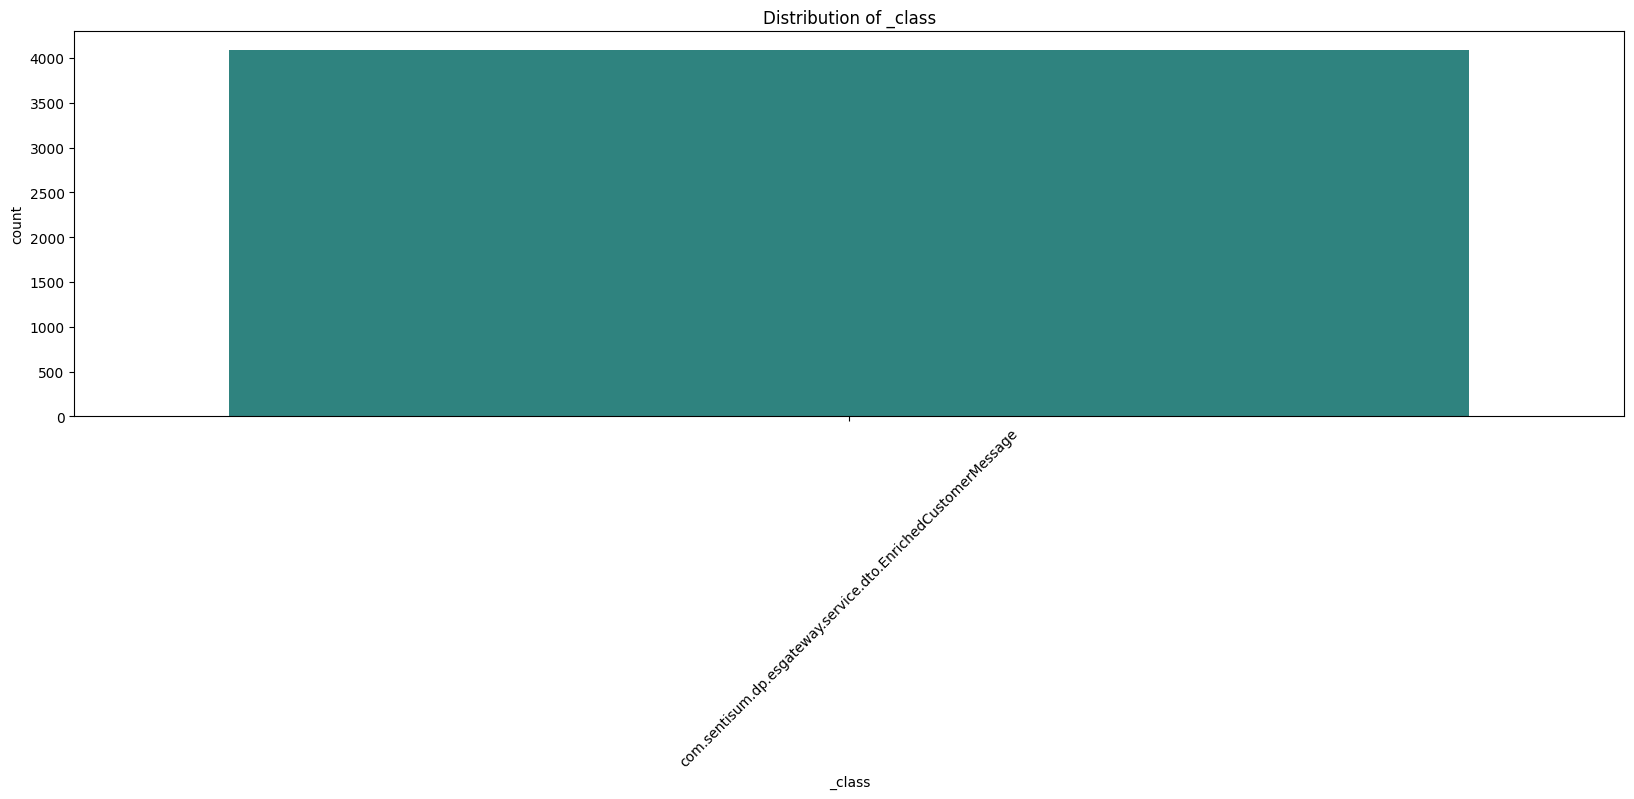

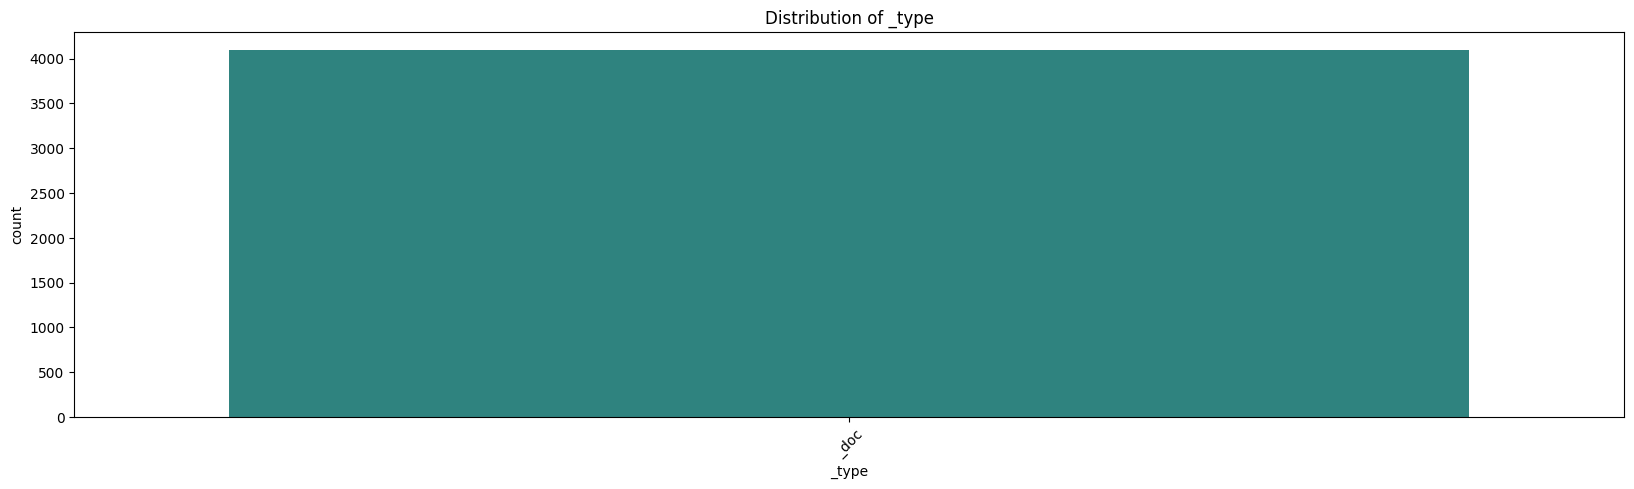

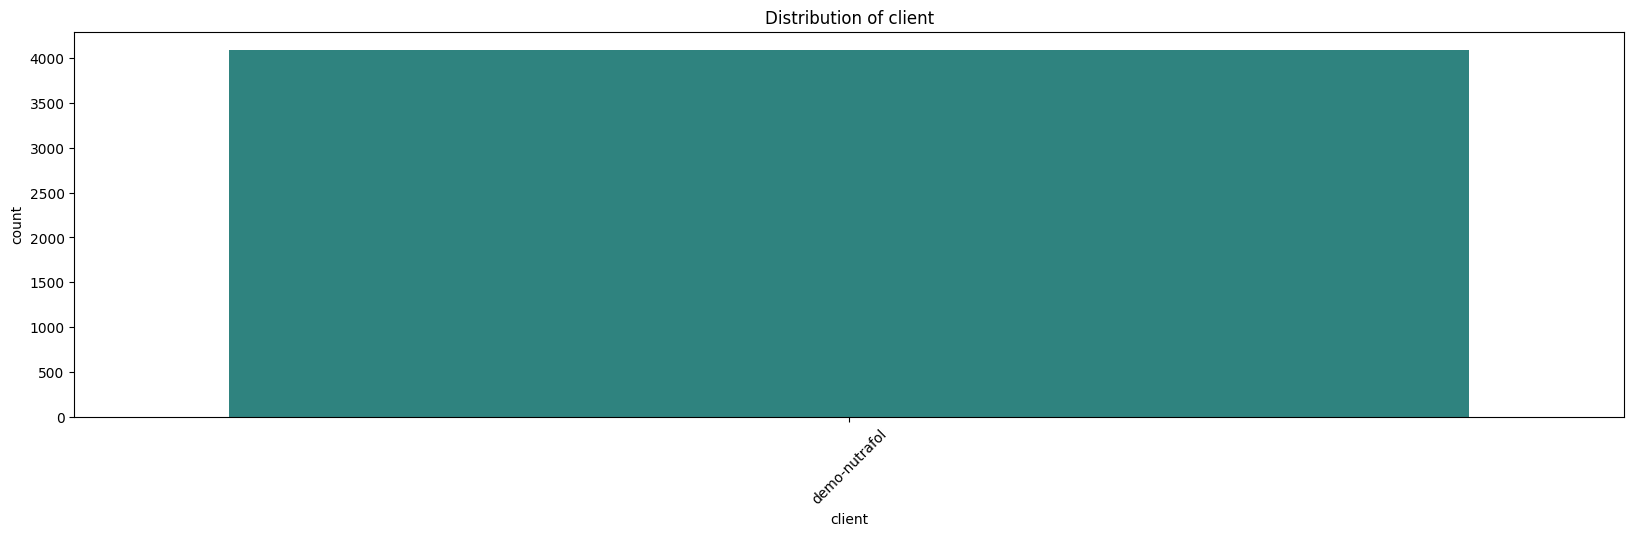

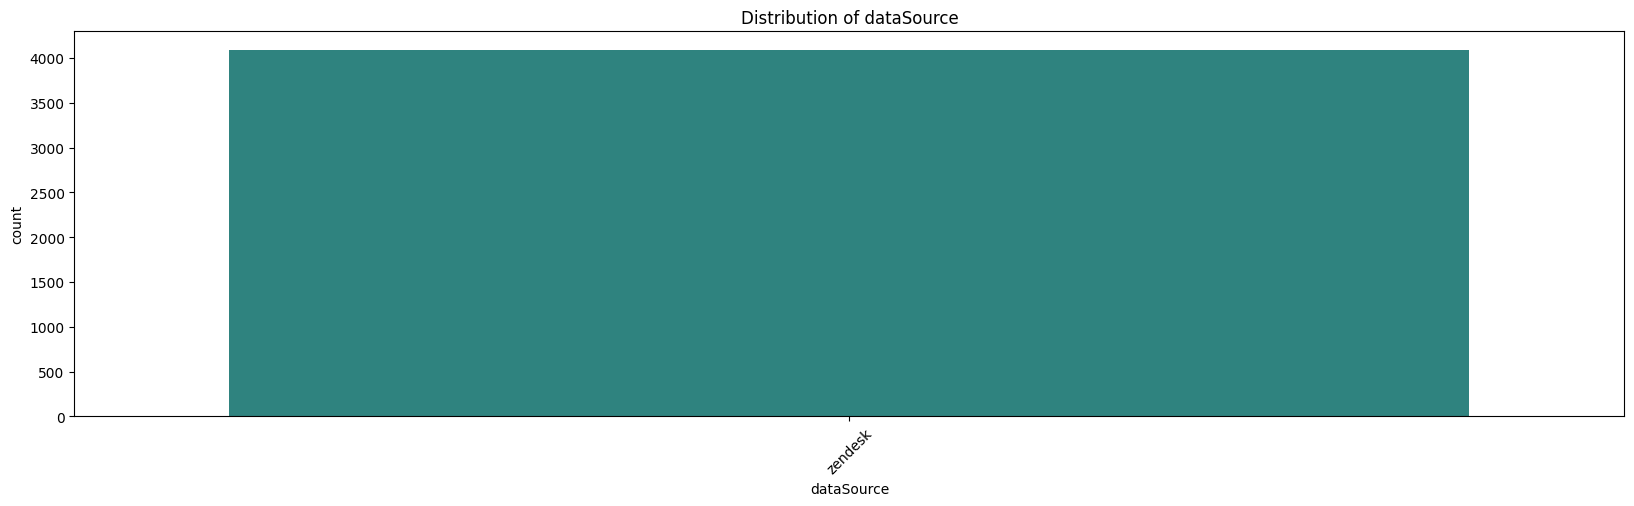

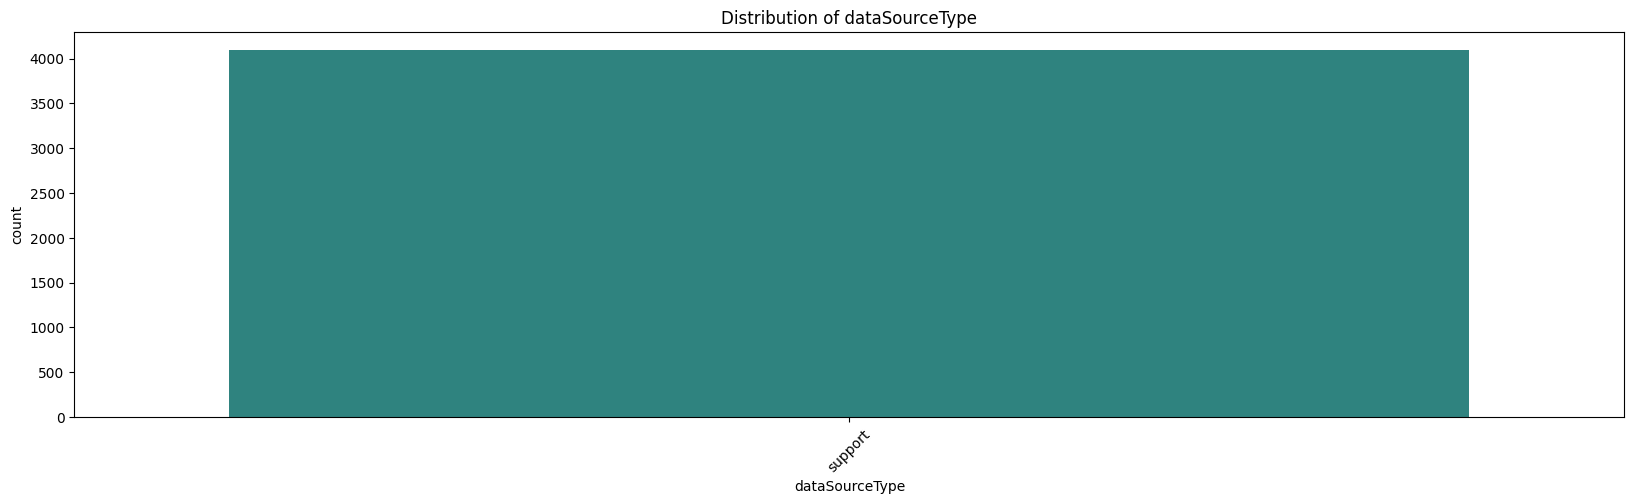

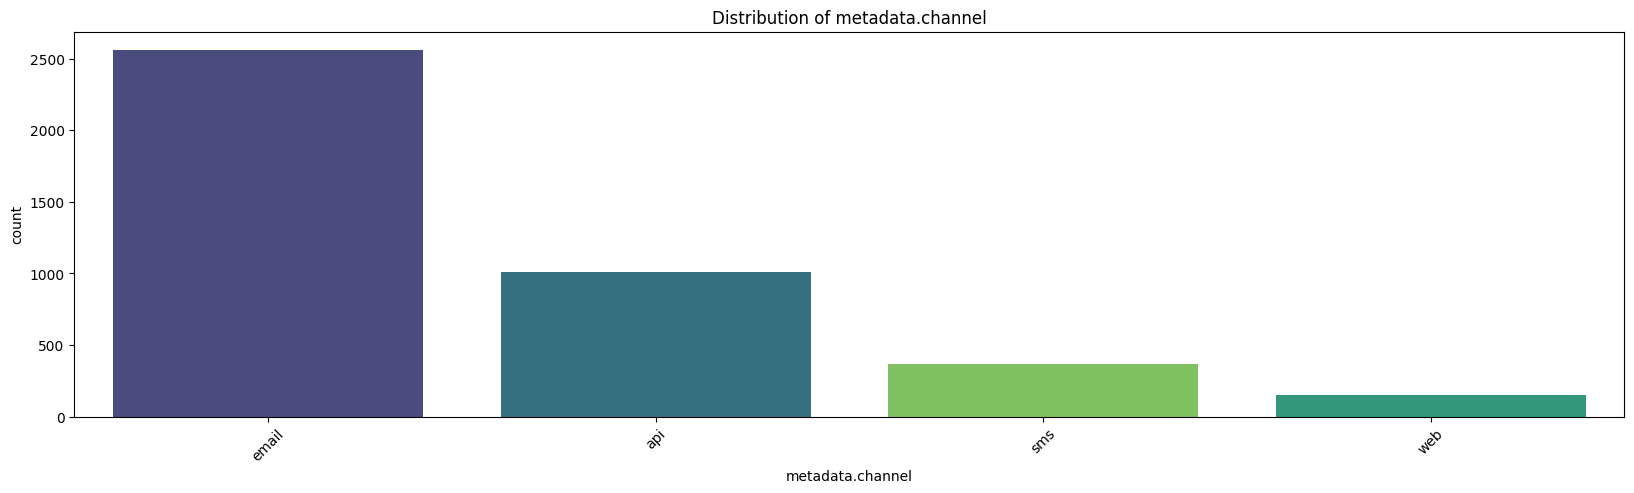

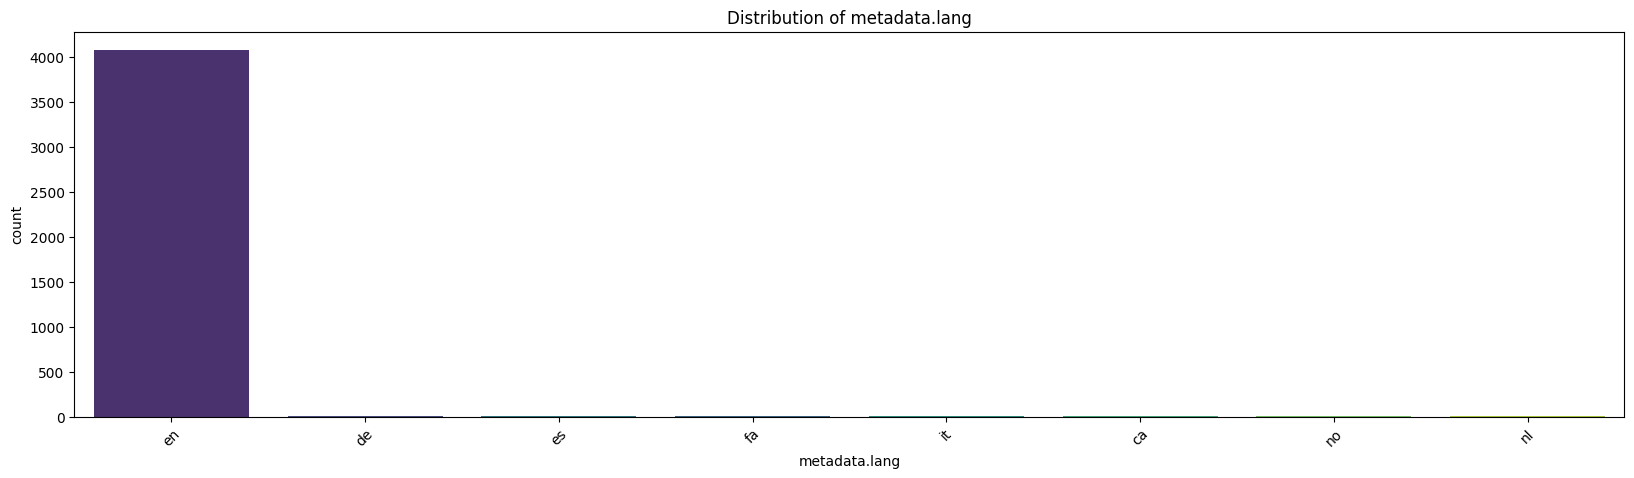

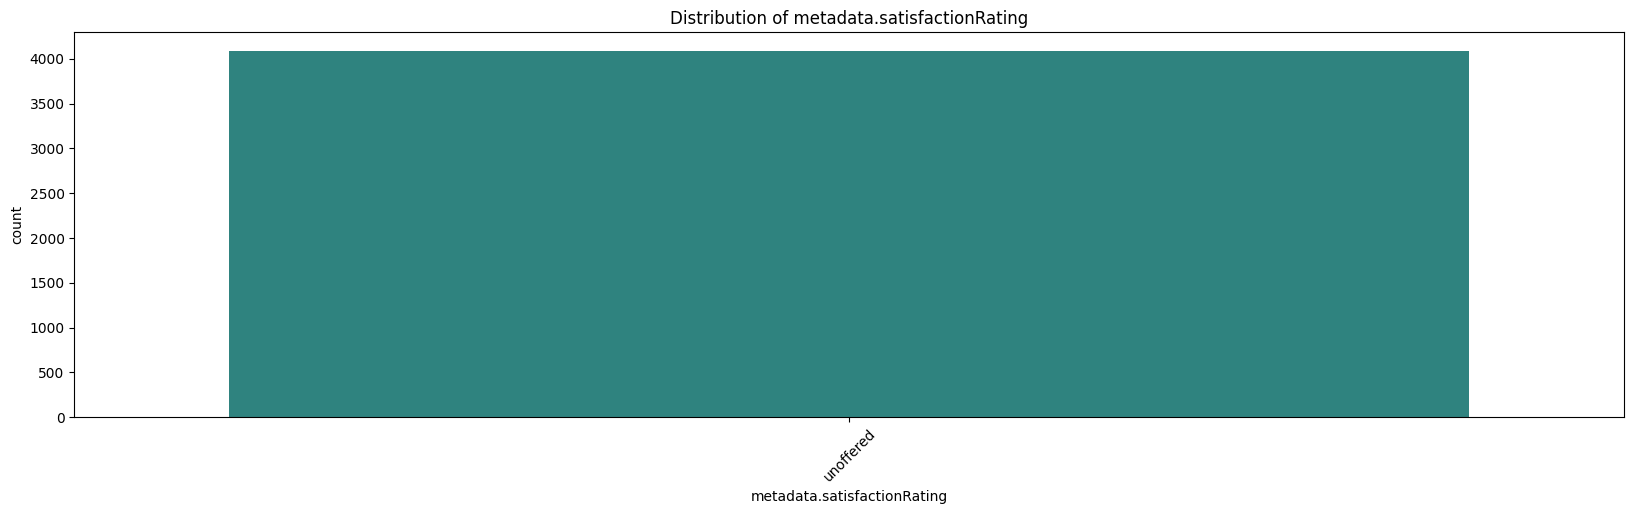

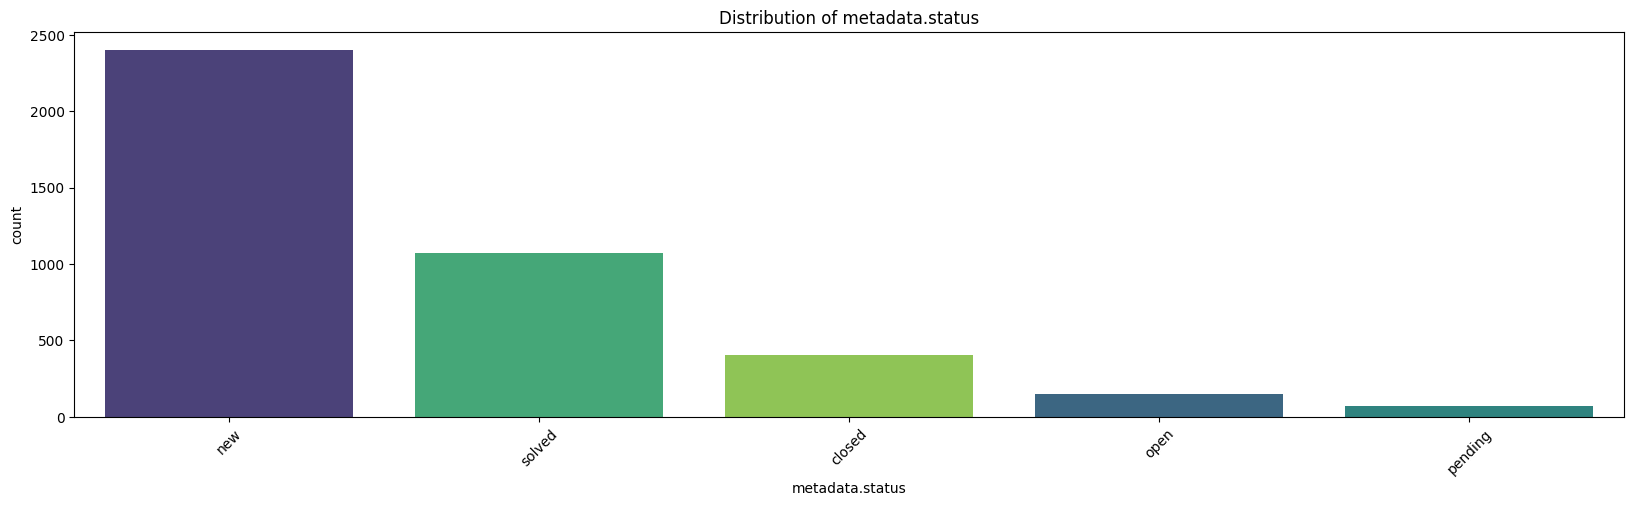

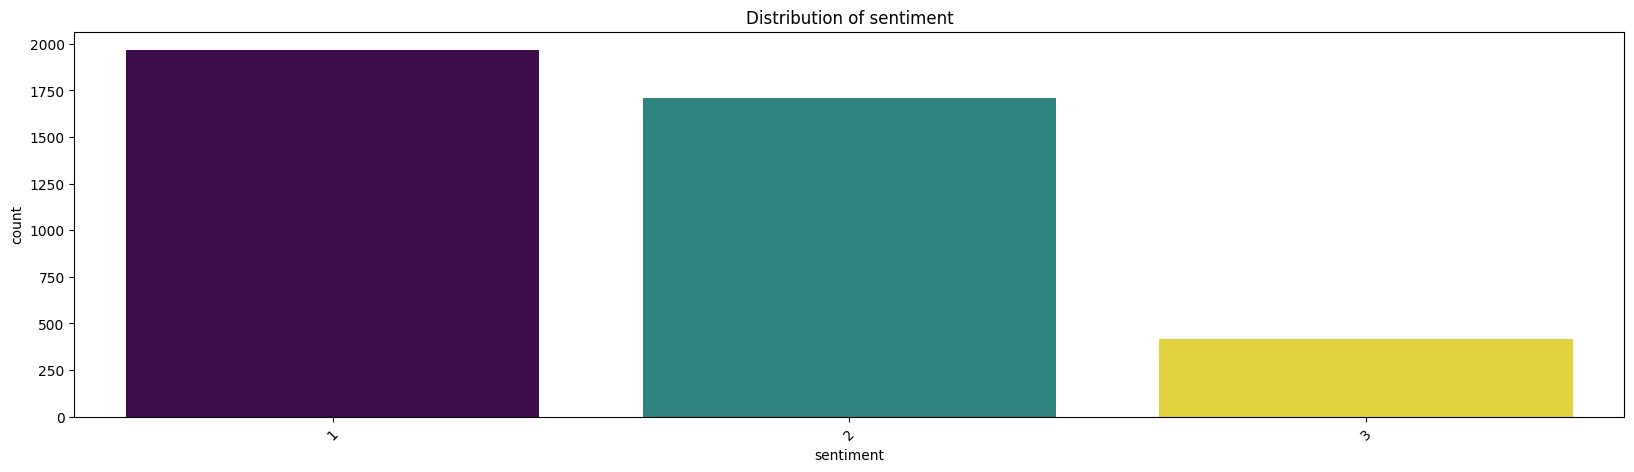

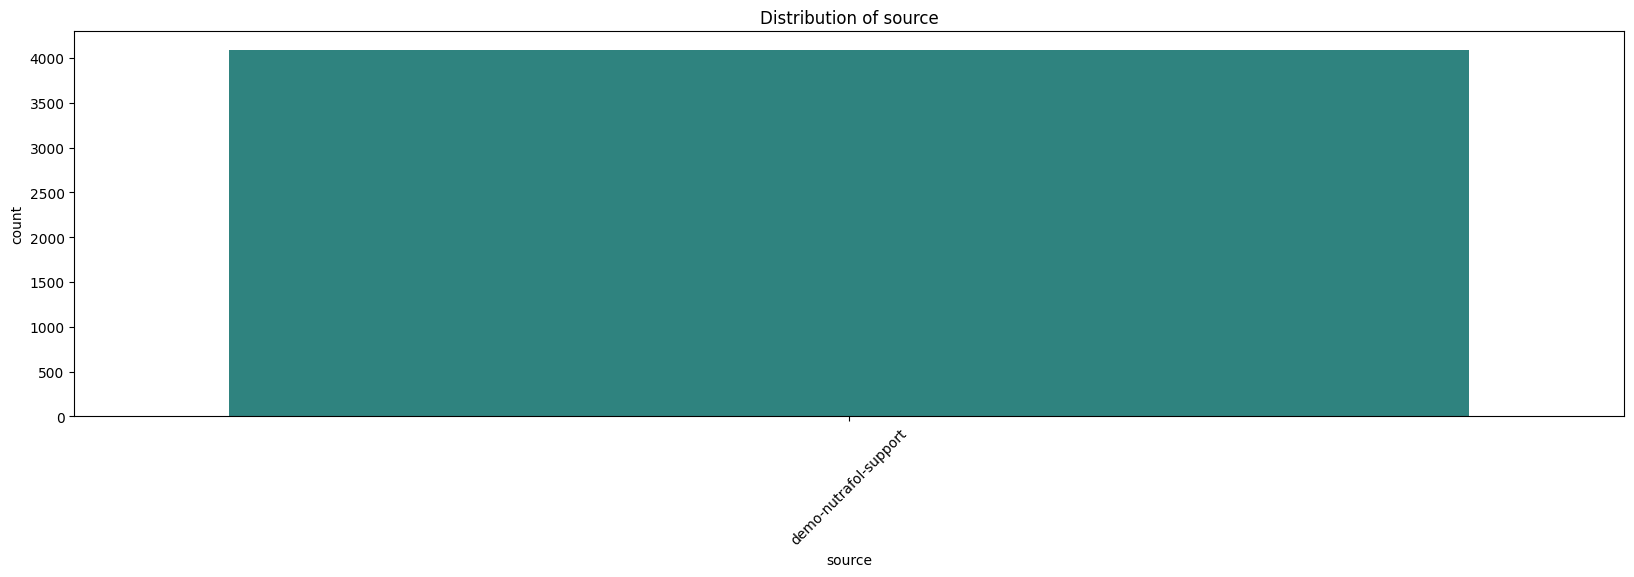

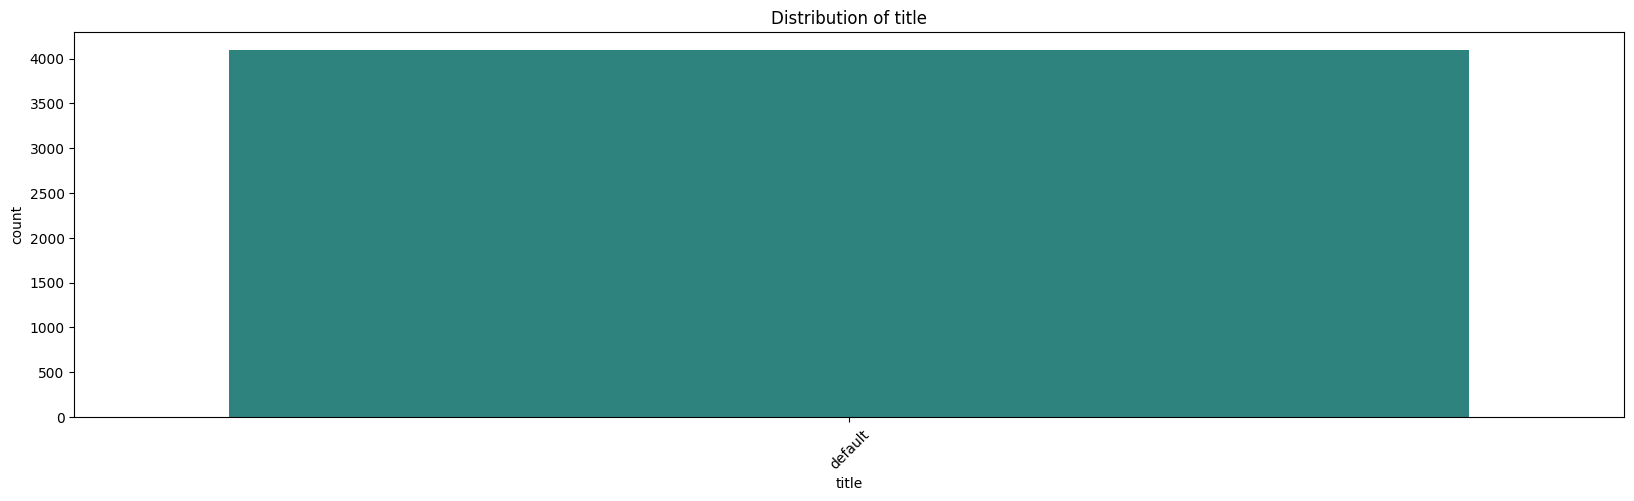




 Columns with only a single unique value:
 :['_class', '_index', '_type', 'client', 'dataSource', 'dataSourceType', 'index', 'metadata.satisfactionRating', 'source', 'title']




In [ ]:
# Function to plot the distribution of categorical columns\
def plot_categorical_distribution(column_name,data_cleaned, palette='viridis'):
    plt.figure(figsize=(20,5))
    sns.countplot(data=data_cleaned, x=column_name, hue=column_name, order=data_cleaned[column_name].value_counts().index, palette=palette, dodge=False)
    plt.title(f'Distribution of {column_name}')
    plt.xticks(rotation=45)
    plt.legend([],[], frameon=False)  # Hide the legend
    plt.show()

# Plot distributions for categorical columns
categorical_columns = ['_class', '_type', 'client', 'dataSource', 'dataSourceType', 'metadata.channel', 'metadata.lang', 'metadata.satisfactionRating', 'metadata.status', 'sentiment', 'source', 'title']
for col in categorical_columns:
    plot_categorical_distribution(col,data_good)

###columns with single value:

# Find columns with only a single unique value
single_value_columns = [col for col in data_good.columns if data_good[col].nunique() == 1]

print(f"\n\n\n Columns with only a single unique value:\n :{single_value_columns}\n\n")


### 🔍 Observations:
1. ['_class', '_index', '_type', 'client', 'dataSource', 'dataSourceType', 'index', 'metadata.satisfactionRating', 'source', 'title'] these columns can be removed as they have only single value, hence do not provide significant value.

In [ ]:
data_good.columns

Index(['_class', '_id', '_index', '_type', 'annotations', 'aspects', 'client',
       'comment', 'comments', 'dataSource', 'dataSourceType', 'datetime',
       'externalId', 'index', 'metadata.channel', 'metadata.lang',
       'metadata.requesterId', 'metadata.satisfactionRating',
       'metadata.status', 'sentiment', 'source', 'title'],
      dtype='object')

In [ ]:
### removing columns with single value
data_good = data_good[[i for i in data_good.columns if i not in single_value_columns ]]
data_good.head()

,_id,annotations,aspects,comment,comments,datetime,externalId,metadata.channel,metadata.lang,metadata.requesterId,metadata.status,sentiment
0,1588411,"[{""theme"":"""",""topic"":""missing item"",""topicAspects"":[""refill joshua lili"",""order today""],""sentiment"":2}]","[""refill joshua lili"",""order today""]",Hi I received my order today and only received a two month supply that included a bottle with a bag of refill Joshua Lili,"[{""createdAt"":""2023-06-21T07:04:09Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hi I received my order today and only received a two month supply that included a bottle with a bag of refill Joshua Lili""}]","Jun 21, 2023 @ 07:04:09.000",1588411,email,en,17779447520275,new,2
1,1588410,"[{""theme"":"""",""topic"":""support responsiveness"",""topicAspects"":[""provided star rating"",""comment terrible customer"",""awful original ticket""],""sentiment"":1},{""theme"":"""",""topic"":""customer support feedback"",""topicAspects"":[""provided star rating"",""comment terrible customer"",""awful original ticket""],""sentiment"":1}]","[""provided star rating"",""comment terrible customer"",""awful original ticket""]",Please follow up with the customer about the feedback they provided Star rating 1 Comment Terrible customer service I would not be going out of my way to leave this message if it was not that awful Original ticket [REDACTED],"[{""createdAt"":""2023-06-21T06:46:43Z"",""authorType"":""Visitor"",""index"":0,""body"":""Please follow up with the customer about the feedback they provided Star rating 1 Comment Terrible customer service I would not be going out of my way to leave this message if it was not that awful Original ticket [REDACTED]""},{""createdAt"":""2023-06-21T15:53:02Z"",""authorType"":""Agent"",""index"":1,""body"":""This request was closed and merged into request #1566318 \""New ticket from dacquaah21@gmail...\"".""}]","Jun 21, 2023 @ 06:46:43.000",1588410,api,en,17194622205459,new,1
2,1588409,"[{""theme"":"""",""topic"":""amend order"",""topicAspects"":[""order"",""add the dht"",""dht blocker""],""sentiment"":2}]","[""order"",""add the dht"",""dht blocker""]",Hi How do I add the DHT blocker to my order? [Mens Hairline Defender 3 Month] Mens Hairline Defender 3 Month Hair Growth ceutical Remove 330 280,"[{""createdAt"":""2023-06-21T06:17:50Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hi How do I add the DHT blocker to my order?""},{""createdAt"":""2023-06-21T06:18:05Z"",""authorType"":""Visitor"",""index"":1,""body"":""[Mens Hairline Defender 3 Month] Mens Hairline Defender 3 Month Hair Growth [REDACTED]ceutical Remove 330 280""}]","Jun 21, 2023 @ 06:17:50.000",1588409,email,en,1524712286321,new,2
3,1588408,"[{""theme"":"""",""topic"":""update customer details"",""topicAspects"":[""credit card link"",""order everytime""],""sentiment"":1},{""theme"":"""",""topic"":""amend subscription"",""topicAspects"":[""credit card link"",""order everytime""],""sentiment"":1},{""theme"":"""",""topic"":""website not working"",""topicAspects"":[""credit card link"",""order everytime""],""sentiment"":1}]","[""credit card link"",""order everytime""]","Hello, I am trying to change my method of payment for my next order Everytime I click the change to credit card link, it takes me to a blank page I have tried this on multiple browsers Is there another way I can change my payment method? Thank you, Rachel Dugger","[{""createdAt"":""2023-06-21T05:57:27Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hello, I am trying to change my method of payment for my next order Everytime I click the change to credit card link, it takes me to a blank page I have tried this on multiple browsers Is there another way I can change my payment method? Thank you, Rachel Dugger""}]","Jun 21, 2023 @ 05:57:27.000",1588408,email,en,17778645159443,new,2
4,1588407,"[{""theme"":"""",""topic"":""change delivery address"",""topicAspects"":[""nick chowning"",""shipping address"",""order number""],""sentiment"":2}

In [ ]:
### checking whether these columns have similar value or not
print(data_good['_id'].equals(data_good['externalId']))

True


### 🔍 Observations:
1. `id` and `externalId` have similar value, hence we can keep only `id`
2. From graph of 'metadata.lang'we can observe that number of conversation in 'en' language is very high as compared to other languages. Hence, we can keep only 'en' conversations. Then we can drop this column too as this only contains 'en'.
3. `datetime`& `metadata.requesterId` do not provide any value to our cause.
4. values of `comment` columns are present in `comments` column. Hence this can be removed.



In [ ]:
### keeping only data where metadata.lang = 'en'
total_rows = data_good['metadata.lang'].value_counts()
# Filter rows where metadata.lang is 'en'
data_good = data_good[data_good['metadata.lang'] == 'en']
total_rows_after = data_good['metadata.lang'].value_counts()
print(f"\nNumber of rows removed for each language:{(total_rows -total_rows_after).fillna(total_rows) }")


Number of rows removed for each language:metadata.lang
ca    1.0
de    6.0
en    0.0
es    3.0
fa    1.0
it    1.0
nl    1.0
no    1.0
Name: count, dtype: float64


In [ ]:
### dropping columns which are not adding values
drop_cols = ['externalId','metadata.requesterId','comment','datetime','metadata.lang']
data_good = data_good.drop(columns=drop_cols)
data_good.head()

,_id,annotations,aspects,comments,metadata.channel,metadata.status,sentiment
0,1588411,"[{""theme"":"""",""topic"":""missing item"",""topicAspects"":[""refill joshua lili"",""order today""],""sentiment"":2}]","[""refill joshua lili"",""order today""]","[{""createdAt"":""2023-06-21T07:04:09Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hi I received my order today and only received a two month supply that included a bottle with a bag of refill Joshua Lili""}]",email,new,2
1,1588410,"[{""theme"":"""",""topic"":""support responsiveness"",""topicAspects"":[""provided star rating"",""comment terrible customer"",""awful original ticket""],""sentiment"":1},{""theme"":"""",""topic"":""customer support feedback"",""topicAspects"":[""provided star rating"",""comment terrible customer"",""awful original ticket""],""sentiment"":1}]","[""provided star rating"",""comment terrible customer"",""awful original ticket""]","[{""createdAt"":""2023-06-21T06:46:43Z"",""authorType"":""Visitor"",""index"":0,""body"":""Please follow up with the customer about the feedback they provided Star rating 1 Comment Terrible customer service I would not be going out of my way to leave this message if it was not that awful Original ticket [REDACTED]""},{""createdAt"":""2023-06-21T15:53:02Z"",""authorType"":""Agent"",""index"":1,""body"":""This request was closed and merged into request #1566318 \""New ticket from dacquaah21@gmail...\"".""}]",api,new,1
2,1588409,"[{""theme"":"""",""topic"":""amend order"",""topicAspects"":[""order"",""add the dht"",""dht blocker""],""sentiment"":2}]","[""order"",""add the dht"",""dht blocker""]","[{""createdAt"":""2023-06-21T06:17:50Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hi How do I add the DHT blocker to my order?""},{""createdAt"":""2023-06-21T06:18:05Z"",""authorType"":""Visitor"",""index"":1,""body"":""[Mens Hairline Defender 3 Month] Mens Hairline Defender 3 Month Hair Growth [REDACTED]ceutical Remove 330 280""}]",email,new,2
3,1588408,"[{""theme"":"""",""topic"":""update customer details"",""topicAspects"":[""credit card link"",""order everytime""],""sentiment"":1},{""theme"":"""",""topic"":""amend subscription"",""topicAspects"":[""credit card link"",""order everytime""],""sentiment"":1},{""theme"":"""",""topic"":""website not working"",""topicAspects"":[""credit card link"",""order everytime""],""sentiment"":1}]","[""credit card link"",""order everytime""]","[{""createdAt"":""2023-06-21T05:57:27Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hello, I am trying to change my method of payment for my next order Everytime I click the change to credit card link, it takes me to a blank page I have tried this on multiple browsers Is there another way I can change my payment method? Thank you, Rachel Dugger""}]",email,new,2
4,1588407,"[{""theme"":"""",""topic"":""change delivery address"",""topicAspects"":[""nick chowning"",""shipping address"",""order number""],""sentiment"":2},{""theme"":"""",""topic"":""what is delivery status"",""topicAspects"":[""products expedited"",""front"",""tracking the shipment""],""sentiment"":1},{""theme"":"""",""topic"":""surplus product"",""topicAspects"":[""week""],""sentiment"":2}]","[""shipping address"",""products expedited"",""tracking the shipment"",""nick chowning"",""week"",""front"",""order number""]","[{""createdAt"":""2023-06-21T05:51:21Z"",""authorType"":""Visitor"",""index"":0,""body"":""My name is Nick Chowning, order number is [REDACTED] Shipping address 4637 Cather Ct, Nashville TN 37214 Package says it was delivered today but I have nothing in front of my house, in the mailbox, in front of the garage etc I checked with my neighbors and no one has the package I tried tracking the shipment and it said it was unavailable Is there any way to get a new package sent with my products expedited? I have enough for this week but was hoping to have my restock today Thank you for your time""}]",email,new,2


In [ ]:
# Get summary information
data_good.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4078 entries, 0 to 4091
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   _id               4078 non-null   int64 
 1   annotations       4078 non-null   object
 2   aspects           4078 non-null   object
 3   comments          4078 non-null   object
 4   metadata.channel  4078 non-null   object
 5   metadata.status   4078 non-null   object
 6   sentiment         4078 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 254.9+ KB


In [ ]:
print(data_good.iloc[0])

_id                                                                                                                                                                                                                    1588411
annotations                                                                                                            [{"theme":"","topic":"missing item","topicAspects":["refill joshua lili","order today"],"sentiment":2}]
aspects                                                                                                                                                                                   ["refill joshua lili","order today"]
comments            [{"createdAt":"2023-06-21T07:04:09Z","authorType":"Visitor","index":0,"body":"Hi I received my order today and only received a two month supply that included a bottle with a bag of refill Joshua Lili"}]
metadata.channel                                                                                            

In [ ]:
# Display 10 random rows with full values and column names
random_rows = data_good.sample(n=10, random_state=1)
random_rows

_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  annotations                                                                                                       aspects                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
random_data_copy = random_rows.copy()

In [ ]:
### rows which contains data_good["annotations"] contains []
empty_annotations_rows = data_good[data_good["annotations"] == "[]"]
print(f" total rows where data_good['annotations'] contains []: {len(empty_annotations_rows)} \nwhich is :{len(empty_annotations_rows) *100 /len(data_good)} % of total data")
print(f"if we remove these we will have : before removal:{len(data_good)}\n after removal: {len(data_good) - len(empty_annotations_rows)} rows")
empty_annotations_rows.head(10)




 total rows where data_good['annotations'] contains []: 417 
which is :10.225600784698381 % of total data
if we remove these we will have : before removal:4078
 after removal: 3661 rows


,_id,annotations,aspects,comments,metadata.channel,metadata.status,sentiment
33,1588374,[],[],"[{""createdAt"":""2023-06-21T02:53:35Z"",""authorType"":""Visitor"",""index"":0,""body"":""Im sending it back""}]",email,new,2
36,1588369,[],[],"[{""createdAt"":""2023-06-21T02:35:17Z"",""authorType"":""Visitor"",""index"":0,""body"":""I dont want this anymore""}]",email,new,1
55,1588347,[],[],"[{""createdAt"":""2023-06-21T01:44:33Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hello I recently purchased a very large order and did not receive a gift of the hair serum Thank you for your assistance Respectfully, Gary Wong Realtor wwwgarywongrealtorcom c [REDACTED] Confidentiality Notice This email and any files attached may contain confidential information that is legally privileged If you are not the intended recipient, or a person responsible for delivering it, you are hereby notified that any disclosure, copying, distribution or use of any of the information contained in or attached to this transmission is strictly prohibited If you have received this transmission in error, please destroy the original transmission and its attachments without reading or saving in any manner""}]",email,new,1
61,1588341,[],[],"[{""createdAt"":""2023-06-21T01:31:15Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hi I think someone stole this package could you resend and put the delivery to place behind the fence near the front door?""}]",email,new,1
65,1588336,[],[],"[{""createdAt"":""2023-06-21T01:25:05Z"",""authorType"":""Visitor"",""index"":0,""body"":""I ordered a 1 time month supply with no subscription and decided to continue I ordered the 3 month subscription and just noticed an email dated June 12, saying my order had shipped I didnt place the order for 3 month subscription until the 18th I am not sure what went wrong, but I would appreciate the issue being resolved Thank you, Cathy Oakley""}]",email,new,2
66,1588335,[],[],"[{""createdAt"":""2023-06-21T01:24:27Z"",""authorType"":""Visitor"",""index"":0,""body"":""I am unable to swallow pills Can I open the capsules and take them""},{""createdAt"":""2023-06-21T01:24:52Z"",""authorType"":""Visitor"",""index"":1,""body"":""I have not ordered""},{""createdAt"":""2023-06-21T13:27:46Z"",""authorType"":""Agent"",""index"":2,""body"":""Hi- thank you for reaching out! We’re happy to help with your inquiry. Happy to answer any questions you might have about [REDACTED]! We know the size of the capsules can be a barrier to some. If this presents any difficulty for you, your Hair Growth [REDACTED]ceutical formula capsules can be opened and mixed into a cool drink or food, such as a smoothie, yogurt, or applesauce. The capsules do not mix well with water. Let me know if I can help with anything else for now. Have a great rest of the day! -- Myshia M. Customer Experience Agent Keep Growing.""}]",sms,new,1
90,1588208,[],[],"[{""createdAt"":""2023-06-21T00:24:01Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hello, Im reaching out because I am currently working on a story for Esquire Magazine on Mens [REDACTED] and the benefits of this particular product If there is anyway to sample the product I would greatly appreciate it Please reach out if you have any questions or concerns and I look forward to hearing from you Kindly Michael""}]",email,new,3
94,1588204,[],[],"[{""createdAt"":""2023-06-21T00:22:25Z"",""authorType"":""Agent"",""index"":0,""body"":""I am a user, for about 8 years, of [REDACTED] hair wellness capsules. I added the collagen to my routine and I'm wondering why I can't buy the collagen separately as I use it more quickly than the capsules. I have 3 bottles of capsules, unused, but am running low on the collagen. Can I order collagen alone?""},{""createdAt"":""2023-06-21T00:23:20Z"",""authorType"":""Agent"",""index"":1,""body"":""My email is dmase100@aol.com.""},{""createdAt"":""2023-06-21T13:25:27Z"",""authorType"":""Agent"",""index"":2,""body"":""Hi Dolores- thank you for reachi

### 🔍 Observations:
1. 'theme' key has no value. We need to remove this. Example: <br>[{"theme":"","topic":"order not received","topicAspects":["yashron holley tsedeq","address yashron holley","yashron holley subject"],"sentiment":3}]
2. `annotations` column has '[]'. We can remove all these rows but `comments` column has values. As we are focusing on creating a conversational AI agent we need to keep these values.
3. In `annotations` column has mutiple dictionaries with the simimlar keys: "theme","topic","topicAspects","sentiment". So we need to consolidate into a single dictionary. <br> We are taking the maximum sentiment value to represent the final sentiment. <br> Example:<br>[{"theme":"","topic":"request replacement","topicAspects":["wellness booster pill","hair wellness booster","hair growth dietary"],"sentiment":1},{"theme":"","topic":"damaged product","topicAspects":["wellness booster pill","hair wellness booster","hair growth dietary"],"sentiment":1}]
4. When metadata_channel = 'api' and 'authorType'= 'visitor' i.e. content originating from APIs has some unnecessary values which need to be removed.<br> Example: <br>
<em>Name Monica Gutierrez Email mgutierrez221gmailcom Phone [REDACTED]  </em>Message I has sent an email and canceled my subscription and then I changed my mind and reactivated it today and I noticed I was double charged Hi there I has sent an email and canceled my subscription and then I changed my mind and reactivated it today and I noticed I was double charged <em>Initialurl [EXTERNALLINK] Browser chrome Browser Version 114000 Device windows Introshown False User Agent Mozilla50 (Windows NT 100 Win64 x64) AppleWebKit53736 (KHTML, like Gecko) Chrome114000 Safari53736 Language en Ip Address [REDACTED] Existing Token eyJraWQiOiIxIiwiYWxnIjoiSFMyNTYifQeyJ1aWQiOjI3MzE5NDQsInV0eXBpZCI6MywiaWF0IjoxNjg2ODUyNjc1LCJleHAiOjE2ODY4NTYyNzV9zpDMMBaF2kYiu4HAEtT34z2Jhyh4JwNrFLziz2FIs Segmentuserid [REDACTED] Last Answer Id 60be8a0bd3b88fb72378c687 Last Question Asked I has sent an email and canceled my subscription and then I changed my mind and reactivated it today and I noticed I was double charged Click Action Verb Click Bypass Handoff Friction True Bypass Live Chat True Bypass Email Submission False In Cx Schedule True Ho Counter 10 Ho Inquiry I has sent an email and canceled my subscription and then I changed my mind and reactivated it today and I noticed I was double charged Handoff Name Monica Gutierrez Handoff Email mgutierrez221gmailcom Handoff Phone [REDACTED] Handoff Ticket Tags ada,adahandoffoffline Chatter Session Token 2207dce12c914a7db4d5a9e05a9424da Chatter Id 648b5[REDACTED]7c95a5a Chatter Token d833d1ba08a848959bda5ab4b9e2ca25 Channel chat</em>

In [ ]:
data_good.columns

Index(['_id', 'annotations', 'aspects', 'comments', 'metadata.channel',
       'metadata.status', 'sentiment'],
      dtype='object')

### Final Observation and key points to consider:
Let's create a class which will be performig following tasks:<br>
1. Read the csv file and store it
2. Keep only important columns : `['_id', 'annotations', 'aspects', 'comments','metadata.channel','metadata.status', 'sentiment']`
3. Remove rows with null values
4. Keep Rows with only 'en' language
5. 'theme' key has no value. Remove this.
6.  In `annotations` column has mutiple dictionaries with the simimlar keys: "theme","topic","topicAspects","sentiment". So we need to consolidate into a single dictionary. <br> We are taking the maximum sentiment value to represent the final sentiment.
7. When metadata_channel = 'api' and 'authorType'= 'visitor' i.e. content originating from APIs has some unnecessary values which need to be removed.
8. The contents from both the Visitor and Agent keys in the comments are to be  extracted and labeled as 'user' and 'agent' in a Q&A format.

In [ ]:
class DataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None
        self.random_row_index = None
        self.load_data()

    def load_data(self):
        """Load the CSV file into a DataFrame."""
        print("Loading data from CSV file...")
        self.df = pd.read_csv(self.file_path)
        print(f"Data loaded. Shape: {self.df.shape}")
        print("Starting data processing...")

        self._keep_important_columns()
        self._remove_null_rows()
        self._keep_english_rows()
        self.random_row_index = random.randint(0, len(self.df) - 1)
        print(f"Random row index selected: {self.random_row_index}")

    def _keep_important_columns(self):
        """Keep only important columns."""
        print("Keeping important columns...")
        important_columns = ['_id', 'annotations', 'aspects', 'comments', 'metadata.channel', 'metadata.status', 'sentiment', 'metadata.lang']
        self.df = self.df[important_columns]
        print(f"Columns kept. New shape: {self.df.shape}")

    def _remove_null_rows(self):
        """Remove rows with null values."""
        print("Removing rows with null values...")
        initial_shape = self.df.shape
        self.df.dropna(inplace=True)
        print(f"Null rows removed. Rows removed: {initial_shape[0] - self.df.shape[0]}. New shape: {self.df.shape}")

    def _keep_english_rows(self):
        """Keep rows with only 'en' language."""
        print("Keeping only English language rows...")
        initial_shape = self.df.shape
        self.df = self.df[self.df['metadata.lang'] == 'en']
        print(f"Non-English rows removed. Rows removed: {initial_shape[0] - self.df.shape[0]}. New shape: {self.df.shape}")

    def remove_theme_key(self):
        """Remove the 'theme' key from annotations."""
        print("\nRemoving 'theme' key from annotations...")
        print("Random row before removing theme key:")
        print(self.df.loc[self.random_row_index, 'annotations'])

        annotations_column = self.df['annotations']
        theme_keys_removed = 0
        for i, annotations_str in annotations_column.items():
            try:
                annotations_list = json.loads(annotations_str.strip(" ' "))
                for annotation in annotations_list:
                    if annotation.pop('theme', None):
                        theme_keys_removed += 1
                annotations_column.at[i] = str(annotations_list)
            except json.JSONDecodeError:
                continue
        print(f"'theme' keys removed from {theme_keys_removed} annotations.")

        print("Random row after removing theme key:")
        print(self.df.loc[self.random_row_index, 'annotations'])

    def aggregate_annotation_data_corrected(self):
        """Consolidate multiple dictionaries in annotations column into a single dictionary."""
        print("\nAggregating annotation data...")
        print("Random row before aggregating annotation data:")
        print(self.df.loc[self.random_row_index, 'annotations'])

        annotations_column = self.df['annotations']
        aggregated_data = []
        for annotations_str in annotations_column:
            try:
                annotations_str_cleaned = annotations_str.replace("'", "\"")
                topics, topic_aspects, sentiments = [], [], []
                annotations_list = json.loads(annotations_str_cleaned)
                for annotation in annotations_list:
                    if 'topic' in annotation:
                        topics.append(annotation['topic'])
                    if 'topicAspects' in annotation:
                        topic_aspects.extend([aspect for aspect in annotation['topicAspects'] if aspect not in topic_aspects])
                    if 'sentiment' in annotation:
                        sentiments.append(annotation['sentiment'])
                aggregated_data.append({
                    'topics': topics,
                    'topicAspects': topic_aspects,
                    'sentiments': None if not sentiments else max(set(sentiments), key=sentiments.count)
                })
            except json.JSONDecodeError:
                aggregated_data.append({'topics': [], 'topicAspects': [], 'sentiments': None})
        self.df['annotations'] = aggregated_data
        print("Annotation data aggregated.")

        print("Random row after aggregating annotation data:")
        print(self.df.loc[self.random_row_index, 'annotations'])

    def process_comments(self):
        print("\nProcessing comments...")
        print("Random row before processing comments:")
        print(self.df.loc[self.random_row_index, 'comments'])

        self.df['processed_comments'] = self.df.apply(lambda x: self._process_comment_entry(x['comments'], x['metadata.channel']), axis=1)
        print("Comments processed.")

        print("Random row after processing comments:")
        print(self.df.loc[self.random_row_index, 'processed_comments'])

    def _process_comment_entry(self, comments_str, metadata_channel):
        processed_comments = []
        try:
            comments_list = json.loads(comments_str.strip("'"))
            for entry in comments_list:
                author_type = entry.get('authorType', '').lower()
                body = entry.get('body', '')
                if metadata_channel == 'api' and author_type == 'visitor':
                    match = re.search(r'message(.*?)initialurl', body, re.IGNORECASE)
                    if match:
                        body = match.group(1).strip()
                if author_type == 'visitor':
                    processed_comments.append({'user': body})
                elif author_type == 'agent':
                    processed_comments.append({'agent': body})
        except json.JSONDecodeError:
            pass
        return processed_comments

    def get_processed_data(self):
        """Return the processed DataFrame."""
        return self.df

    def process(self):
        self.remove_theme_key()
        self.aggregate_annotation_data_corrected()
        self.process_comments()
        print("Data processing completed.")


In [ ]:
# Get the file path from the environment variable
file_path = os.getenv('ASSESSMENT_CSV_PATH')

# Check if the environment variable is set and the file path is valid
if file_path:
    print("File path retrieved from environment variable:", file_path)
else:
    print("Environment variable ASSESSMENT_CSV_PATH is not set.")


processor = DataProcessor(file_path)
processor.process()
final_data = processor.get_processed_data()

File path retrieved from environment variable: /content/drive/MyDrive/LLM_RAG_application/customer_care/support_chat.csv
Loading data from CSV file...
Data loaded. Shape: (4092, 64)
Starting data processing...
Keeping important columns...
Columns kept. New shape: (4092, 8)
Removing rows with null values...
Null rows removed. Rows removed: 0. New shape: (4092, 8)
Keeping only English language rows...
Non-English rows removed. Rows removed: 14. New shape: (4078, 8)
Random row index selected: 1865

Removing 'theme' key from annotations...
Random row before removing theme key:
[{"theme":"","topic":"cancel subscription","topicAspects":["suspend my deliveries","deliveries from sept"],"sentiment":2},{"theme":"","topic":"pause subscription","topicAspects":["suspend my deliveries","deliveries from sept"],"sentiment":2}]
'theme' keys removed from 0 annotations.
Random row after removing theme key:
[{'topic': 'cancel subscription', 'topicAspects': ['suspend my deliveries', 'deliveries from sept']

In [ ]:
final_data.head()

,_id,annotations,aspects,comments,metadata.channel,metadata.status,sentiment,metadata.lang,processed_comments
0,1588411,"{'topics': ['missing item'], 'topicAspects': ['refill joshua lili', 'order today'], 'sentiments': 2}","[""refill joshua lili"",""order today""]","[{""createdAt"":""2023-06-21T07:04:09Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hi I received my order today and only received a two month supply that included a bottle with a bag of refill Joshua Lili""}]",email,new,2,en,[{'user': 'Hi I received my order today and only received a two month supply that included a bottle with a bag of refill Joshua Lili'}]
1,1588410,"{'topics': ['support responsiveness', 'customer support feedback'], 'topicAspects': ['provided star rating', 'comment terrible customer', 'awful original ticket'], 'sentiments': 1}","[""provided star rating"",""comment terrible customer"",""awful original ticket""]","[{""createdAt"":""2023-06-21T06:46:43Z"",""authorType"":""Visitor"",""index"":0,""body"":""Please follow up with the customer about the feedback they provided Star rating 1 Comment Terrible customer service I would not be going out of my way to leave this message if it was not that awful Original ticket [REDACTED]""},{""createdAt"":""2023-06-21T15:53:02Z"",""authorType"":""Agent"",""index"":1,""body"":""This request was closed and merged into request #1566318 \""New ticket from dacquaah21@gmail...\"".""}]",api,new,1,en,"[{'user': 'Please follow up with the customer about the feedback they provided Star rating 1 Comment Terrible customer service I would not be going out of my way to leave this message if it was not that awful Original ticket [REDACTED]'}, {'agent': 'This request was closed and merged into request #1566318 ""New ticket from dacquaah21@gmail..."".'}]"
2,1588409,"{'topics': ['amend order'], 'topicAspects': ['order', 'add the dht', 'dht blocker'], 'sentiments': 2}","[""order"",""add the dht"",""dht blocker""]","[{""createdAt"":""2023-06-21T06:17:50Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hi How do I add the DHT blocker to my order?""},{""createdAt"":""2023-06-21T06:18:05Z"",""authorType"":""Visitor"",""index"":1,""body"":""[Mens Hairline Defender 3 Month] Mens Hairline Defender 3 Month Hair Growth [REDACTED]ceutical Remove 330 280""}]",email,new,2,en,"[{'user': 'Hi How do I add the DHT blocker to my order?'}, {'user': '[Mens Hairline Defender 3 Month] Mens Hairline Defender 3 Month Hair Growth [REDACTED]ceutical Remove 330 280'}]"
3,1588408,"{'topics': ['update customer details', 'amend subscription', 'website not working'], 'topicAspects': ['credit card link', 'order everytime'], 'sentiments': 1}","[""credit card link"",""order everytime""]","[{""createdAt"":""2023-06-21T05:57:27Z"",""authorType"":""Visitor"",""index"":0,""body"":""Hello, I am trying to change my method of payment for my next order Everytime I click the change to credit card link, it takes me to a blank page I have tried this on multiple browsers Is there another way I can change my payment method? Thank you, Rachel Dugger""}]",email,new,2,en,"[{'user': 'Hello, I am trying to change my method of payment for my next order Everytime I click the change to credit card link, it takes me to a blank page I have tried this on multiple browsers Is there another way I can change my payment method? Thank you, Rachel Dugger'}]"
4,1588407,"{'topics': ['change delivery address', 'what is delivery status', 'surplus product'], 'topicAspects': ['nick chowning', 'shipping address', 'order number', 'products expedited', 'front', 'tracking the shipment', 'week'], 'sentiments': 2}","[""shipping address"",""products expedited"",""tracking the shipment"",""nick chowning"",""week"",""front"",""order number""]","[{""createdAt"":""2023-06-21T05:51:21Z"",""authorType"":""Visitor"",""index"":0,""body"":""My name is Nick Chowning, order number is [REDACTED] Shipping address 4637 Cather Ct, Nashville TN 37214 Package says it was delivered today but I have nothing in 

In [ ]:
final_data.columns

Index(['_id', 'annotations', 'aspects', 'comments', 'metadata.channel',
       'metadata.status', 'sentiment', 'metadata.lang', 'processed_comments'],
      dtype='object')

# 👥 **Creating Conversations and Metadata**

  Here we parse data in the respective format-- <br>
  Conversation: <br>
  `['<USER> Hi I received my order today and only received a two month supply that included a bottle with a bag of refill Joshua Lili ', '<USER> Please follow up with the customer about the feedback they provided Star rating 1 Comment Terrible customer service I would not be going out of my way to leave this message if it was not that awful Original ticket REDACTED <AGENT> This request was closed and merged into request 1566318 New ticket from dacquaah21gmail ', '<USER> Hi How do I add the DHT blocker to my order <USER> Mens Hairline Defender 3 Month Mens Hairline Defender 3 Month Hair Growth REDACTEDceutical Remove 330 280 ']`<br><br>
  Metadata: <br>
`[{'topics': 'missing item', 'topicAspects': 'refill joshua lili order today', 'sentiments': '2', 'channel': 'email', 'status': 'new'}, {'topics': 'support responsiveness customer support feedback', 'topicAspects': 'provided star rating comment terrible customer awful original ticket', 'sentiments': '1', 'channel': 'api', 'status': 'new'}, {'topics': 'amend order', 'topicAspects': 'order add the dht dht blocker', 'sentiments': '2', 'channel': 'email', 'status': 'new'}]`<br><br>

  To format the lists of final_test, final_id, and final_metadata compatible with Vector DB, we need to ensure that each entry is structured appropriately for storage. Vector DB typically requires a structured format such as JSON.

  **Note:- here we are using two special tokens `<USER>` and `<AGENT>` to be encapsulated befor the user question or the agent's answer , so that our model can distinct between the two.**




In [ ]:

class ConversationProcessor:
    USER_TOKEN = "<USER>"
    AGENT_TOKEN = "<AGENT>"

    def __init__(self, final_data):
        self.final_data = final_data
        self.conversations = []
        self.final_text = []
        self.final_id = []
        self.final_metadata = []
        self.converted_metadata = []
        print(f"Initialized ConversationProcessor with {len(final_data)} rows of data")

    def process_data(self):
        print("Starting data processing...")
        self.construct_conversations()
        self.process_conversations()
        self.convert_metadata()
        print("Data processing complete")

    def construct_conversations(self):
        print("Constructing conversations...")
        for index, row in self.final_data.iterrows():
            conversation = {
                "conversation_id": str(row["_id"]),
                "interactions": ast.literal_eval(str(row["processed_comments"])),
                "metadata": ast.literal_eval(str(row["annotations"])),
                "channel": row.get("metadata.channel", ""),
                "status": row.get("metadata.status", "")
            }
            self.conversations.append(conversation)
        print(f"Constructed {len(self.conversations)} conversations")

    def clean_text(self, text):
        cleaned_text = re.sub(r"[^a-zA-Z0-9\s" + re.escape(self.USER_TOKEN + self.AGENT_TOKEN) + "]", "", text)
        return cleaned_text.strip()

    def process_conversations(self):
        print("Processing conversations...")
        for conversation in self.conversations:
            conversation_text = ""
            for turn in conversation["interactions"]:
                if 'user' in turn:
                    user_text = self.clean_text(turn['user'])
                    conversation_text += f"{self.USER_TOKEN} {user_text} "
                if 'agent' in turn:
                    agent_text = self.clean_text(turn['agent'])
                    conversation_text += f"{self.AGENT_TOKEN} {agent_text} "

            self.final_id.append(conversation['conversation_id'])
            self.final_text.append(conversation_text)

            metadata = conversation['metadata']
            metadata['channel'] = conversation['channel']
            metadata['status'] = conversation['status']
            self.final_metadata.append(metadata)

        print(f"Processed {len(self.final_id)} conversations")
        if self.final_id:
            print(f"Sample final_id ID: {self.final_id[0]}")
            print(f"Sample conversation text: {self.final_text[0]}")  # Print first 100 characters
            print(f"Sample metadata: {self.final_metadata[0]}")

    def value_to_string(self, value):
        if isinstance(value, list):
            return ' '.join(map(str, value))
        return str(value)

    def convert_metadata(self):
        print("Converting metadata...")
        for item in self.final_metadata:
            converted_item = {k: self.value_to_string(v) for k, v in item.items()}
            self.converted_metadata.append(converted_item)
        print(f"Converted {len(self.converted_metadata)} metadata items")
        if self.converted_metadata:
            print(f"Sample converted metadata: {self.converted_metadata[0]}")  # Print first 5 items

In [ ]:
# Usage
Conversations= ConversationProcessor(final_data)
Conversations.process_data()
# Now you can access the processed data
print(Conversations.final_text[:3])  # Print first few entries of the processed text
print(Conversations.converted_metadata[:3])  # Print first few entries of the converted metadata

Initialized ConversationProcessor with 4078 rows of data
Starting data processing...
Constructing conversations...
Constructed 4078 conversations
Processing conversations...
Processed 4078 conversations
Sample final_id ID: 1588411
Sample conversation text: <USER> Hi I received my order today and only received a two month supply that included a bottle with a bag of refill Joshua Lili 
Sample metadata: {'topics': ['missing item'], 'topicAspects': ['refill joshua lili', 'order today'], 'sentiments': 2, 'channel': 'email', 'status': 'new'}
Converting metadata...
Converted 4078 metadata items
Sample converted metadata: {'topics': 'missing item', 'topicAspects': 'refill joshua lili order today', 'sentiments': '2', 'channel': 'email', 'status': 'new'}
Data processing complete
['<USER> Hi I received my order today and only received a two month supply that included a bottle with a bag of refill Joshua Lili ', '<USER> Please follow up with the customer about the feedback they provided Star ratin

# 📑 **Data Indexing and Querying**

1. **Vector Database:** Using **ChromaDB** from the Langchain community open-source vector database. ChromaDB provides capabilities for storing and querying vector embeddings efficiently.

2. **Embedding Model:** Opted for the **HuggingFaceEmbeddings-all-mpnet-base-v2 model**, which is based on the Sentence Transformers base model. This model allows you to generate embeddings for sentences or text passages. Since our chats consist of multiple sentences separated by special tokens, using a sentence transformer-based model is suitable for preserving the structure of our conversations.

3. **Embedding Generation:** Used the chosen model (HuggingFaceEmbeddings-all-mpnet-base-v2) to generate embeddings for each sentence in our chat conversations.

4. **Data Storage:** Store the generated embeddings along with the associated metadata (such as chat IDs,annotations, etc.) in ChromaDB.

5. **Querying and Retrieval:** Implement mechanisms to query ChromaDB for retrieving embeddings based on queries

With this setup, we can efficiently stored and retrieve embeddings for our chat conversations using ChromaDB and the chosen embedding model.








In [ ]:
# Initialize a new Hugging Face embeddings model using the specified model_name ("all-mpnet-base-v2")
new_embedding = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")

# Create a Chroma instance and index texts, embeddings, metadata, and IDs into the database
vectordb = Chroma.from_texts(
    texts=Conversations.final_text,  # Texts to be indexed
    embedding=new_embedding,  # Embeddings to be indexed
    metadatas=Conversations.converted_metadata,  # Metadata associated with the texts
    ids=Conversations.final_id,  # IDs associated with the texts
    collection_name="rag_application"  # Name of the collection in the database
)

# Convert the indexed database into a retriever for search purposes, specifying search parameters
retriever = vectordb.as_retriever(search_kwargs={"k": 5})

# Retrieve relevant documents based on the query "How can i get refund?"
docs = retriever.get_relevant_documents("How can i get refund?")

# Calculate the number of relevant documents retrieved
len(docs)


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


5

# 🧠 **Quantized LLM**


1. **Model and Tokenizer:** The code initializes a tokenizer using the pretrained model name 'mistralai/Mistral-7B-Instruct-v0.1'. Mistral-7B-Instruct prioritizes accuracy and context-awareness. Its use of rolling buffer caching efficiently retains relevant information across sequences

2. **Efficient Model Loading:** By utilizing 4-bit precision base model loading (use_4bit=True), the code optimizes memory usage during model loading. it reduces the memory footprint and accelerates loading times.

3. **Quantization for Reduced Precision:** The code implements quantization techniques such as "nf4" (nearest float 4-bit) to reduce the precision of model parameters and computations. This reduction in precision helps conserve memory and computation resources.




In [ ]:
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain

In [ ]:

model_name='mistralai/Mistral-7B-Instruct-v0.1'


tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

#################################################################
# bitsandbytes parameters
#################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

#################################################################
# Set up quantization config
#################################################################
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

#################################################################
# Load pre-trained config
#################################################################
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
)

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

# 🚰 **Pipeline**

**Here we use the Hugging Face pipeline in our code for streamlining the approach to integrate our model, tokenizer, and configurable parameters into a cohesive workflow.**



In [ ]:
text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.0,
    # repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=1000,
)

mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


# 📋 **Templates**


The provided code defines multiple prompt templates aimed at enhancing the efficiency of your model. Here's a breakdown of each template:

1. **Template 1:**
Instructs to answer truthfully using provided context.

2. **Template 2**:
Answer question using provided context. If context is insufficient, respond accordingly.

3. **Template 3:**
Answer question using provided context. If context is insufficient, respond accordingly. Avoid sharing personal details.

4. **Template 4:**
Answer question using context. If context is insufficient, respond accordingly. Avoid personal details and specified restricted topics.

5. **Template 5:**
Answer question using context. If context is insufficient, respond accordingly. Avoid personal details and specified restricted topics (marked as urgent).


**Note:**- These templates helps us in providing features like

1. **Removing personal Information**

2. **Answers only on the Available data**

3. **Ban specific phrases/ restricted topics to generate query**

In [ ]:
# Define your list of restricted topics
restricted_topics_list = ["refund", "subscription"]
formatted_restricted_topics = ", ".join(restricted_topics_list)

# Template1
prompt_template1 = """
### [INST] Instruction: "Answer the question as truthfully as possible using the provided context, and if the answer is not contained within the context and requires some latest information to be updated, print 'Sorry Not Sufficient context to answer query'":

{context}

### QUESTION:
{question} [/INST]
"""

# Template2
prompt_template2 = """
### [INST] Instruction:
Answer the question below using the provided context. If the context contains relevant information to answer the question, use that information to provide a response. If the context does not contain the necessary information or is insufficient to form a complete answer, respond with 'Sorry, not sufficient context to answer this query.'

### CONTEXT:
{context}

### QUESTION:
{question}

### ANSWER:
"""

# Template3
prompt_template3 = """
### [INST] Instruction: You are Friday, a friendly and helpful AI assistant. Your personality is cheerful, knowledgeable, and always eager to assist. Your primary task is to answer questions using the provided context, but you should also engage in casual conversation when appropriate.
1. Do not introduce yourself unless this is explicitly stated to be the first interaction or the user specifically asks about your name or identity.
2. If the user's message is a greeting (e.g., "hello", "hi", "good morning") or casual conversation, respond in a friendly and appropriate manner without introducing yourself. You don't need to use the context for these responses.
3. For questions or requests for information:
   - If the context contains relevant information, use it to provide a response.
   - If the context does not contain the necessary information or is insufficient, respond with "I'm afraid I don't have enough information to answer that question accurately. Is there anything else I can help you with?"
4. Always maintain a friendly, helpful, and slightly cheerful tone. You can use light humor when appropriate.
5. Do not share any specific personal details such as names, addresses, or email addresses in your response. But answer in a detailed step-by-step process when appropriate.
6. Only if explicitly asked about your capabilities or identity, you can say: "I'm Friday, an AI assistant created to help with a wide range of tasks and questions. I'm knowledgeable about many topics and always eager to learn more through our conversations!"
7. For all other responses, focus on directly addressing the user's input without introducing yourself.
8. Do not create or use any random user names in your responses. Address the user simply as "you"
9. Avoid making assumptions about the user's identity or personal information. Stick to the information provided in the user's input.

### CONTEXT: {context}
### USER INPUT: {user_input}
### FRIDAY'S RESPONSE:
"""




# 🦜🔗 **LLM Chain**


**Here we used the LLM chain architecture allowing for easy integration of various components such as retrievers, prompts, and language models.
Here Prompts provide structured input to the language model, guiding the generation of coherent and contextually relevant responses**

In [ ]:
# Define the prompt template using PromptTemplate
prompt = PromptTemplate(
    input_variables=["context", "user_input"],
    template=prompt_template3,
)
# Initialize the LLMChain with the specified language model (mistral_llm) and prompt template
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt)

# Define the RAG (Retriever-Generator) chain using a pipeline of components
rag_chain = (
    {"context": retriever, "user_input": RunnablePassthrough()}
    | llm_chain
)

# First interaction
response = rag_chain.invoke("Hello there!")
# Friday will introduce itself




/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:

# Question about capabilities
rag_chain.invoke("What can you do, Friday?")
# Friday will respond with information about its capabilities

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


{'context': [Document(metadata={'channel': 'email', 'sentiments': '2', 'status': 'solved', 'topicAspects': 'skip this order', 'topics': 'pause subscription'}, page_content='<USER> Please skip this order Thank you <AGENT> Hi Katherine Thank you for reaching out Were happy to help with your inquiry At this time your June 17th order has already been processed and cannot be canceled To avoid the hassle of a return I can refund you 50 of your order and you can keep it I can also adjust your next bill date to a later date of your choice If youd prefer this option please let me know right away and Ill issue the refund If youd like to return the order for a full refund please use the instructions below Please make sure to mail this return by July 17th Any product you return must be unopened and unused If your products are still in the original sealed shipping box please take the package to a post office USPS and ask to process a return to sender making sure not to open the outer shipping box R

In [ ]:
# Information request
rag_chain.invoke("How can we cancel our subscription?")
# Friday will use the context to answer, maintaining its personality

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


{'context': [Document(metadata={'channel': 'api', 'sentiments': '1', 'status': 'new', 'topicAspects': 'gee email michellegeehomesgmailcom chrome browser version email michellegeehomesgmailcom gatsbytoken michelle gee email cancel subscription single email michellegeehomesgmailcom phone', 'topics': 'cancel subscription switch to/from vegan'}, page_content='<USER> Cancel subscription Hello How can I cancel my subscription '),
  Document(metadata={'channel': 'api', 'sentiments': '1', 'status': 'new', 'topicAspects': 'device macos introshown catherine steel email email cmsteelverizonnet phone steel email cmsteelverizonnet macintosh intel mac cancel subscription single', 'topics': 'cancel subscription'}, page_content='<USER> I want to cancel my subscription and need help to do so Hello I do not see a place where I can cancel How do I cancel the subscription manually <AGENT> Hi Catherine Thank you for reaching out Were happy to help with your inquiry It looks like you found your way around o

In [ ]:
torch.cuda.empty_cache()

# 📱 **Chat Interface**


**Using Gradio to create a chat interface:**

 It offers a user-friendly and versatile framework for building chat interfaces that are interactive, customizable, and seamlessly integrated with our models used for conversational agents.


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install gradio==3.48.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 32.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.1 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5584 sha256=006ce9f695943062944286a95295d2570012d2edad0e2d41069411fd17bb817b
  Stored in directory: /root/.cache/pip/wheels/bd/65/9a/671fc6dcde07d4418df0c592f8df512b26d7a0029c2a23dd81
Successfully built ffmpy
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0


In [ ]:
import gradio as gr

def extract_friday_response(full_text):
    parts = full_text.split("### FRIDAY'S RESPONSE:")
    if len(parts) > 1:
        return parts[1].strip()
    else:
        return "I'm sorry, could you please elaborate?"

def is_farewell(user_input):
    farewells = ["bye", "goodbye", "see you", "farewell", "take care"]
    return any(word in user_input.lower() for word in farewells)

def chatbot_interface(user_input, history):
    if is_farewell(user_input):
        farewell_response = "I hope I helped you. Thank you for your time. Let me know if I can help you with anything else. Bye bye!"
        return "", history + [(user_input, farewell_response)], history + [(user_input, farewell_response)]

    response = rag_chain.invoke(user_input)
    full_text = response['text']
    friday_answer = extract_friday_response(full_text)

    is_first_interaction = len(history) == 0
    is_asking_identity = "who are you" in user_input.lower() or "what's your name" in user_input.lower()

    if is_first_interaction or is_asking_identity:
        introduction = "Hi there! I'm Friday, your friendly AI assistant. "
        friday_answer = introduction + friday_answer

    visible_history = history + [(user_input, friday_answer)]
    full_history = history + [(user_input, friday_answer)]

    return "", visible_history, full_history

# Create the Gradio interface
with gr.Blocks(theme="soft") as iface:
    gr.Markdown("# Chat with Friday")
    gr.Markdown("Friday is your friendly AI assistant. Ask anything!")

    with gr.Row():
        with gr.Column(scale=1):
            msg = gr.Textbox(
                placeholder="Type your message here... (Press Enter to send, Shift+Enter for new line)",
                label="User Input",
                lines=1,
                max_lines=5
            )
            submit_button = gr.Button("Submit")

        with gr.Column(scale=1):
            chatbot = gr.Chatbot(label="Chat with Friday")

    state = gr.State([])

    # Define the submit action
    def on_submit(message, chat_history):
        return chatbot_interface(message, chat_history)

    # Connect the submit action to both the button and the textbox
    submit_button.click(on_submit, inputs=[msg, state], outputs=[msg, chatbot, state])
    msg.submit(on_submit, inputs=[msg, state], outputs=[msg, chatbot, state])

# Launch the interface
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.48.0, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://865cb9f38005c8049e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Examples: <br>
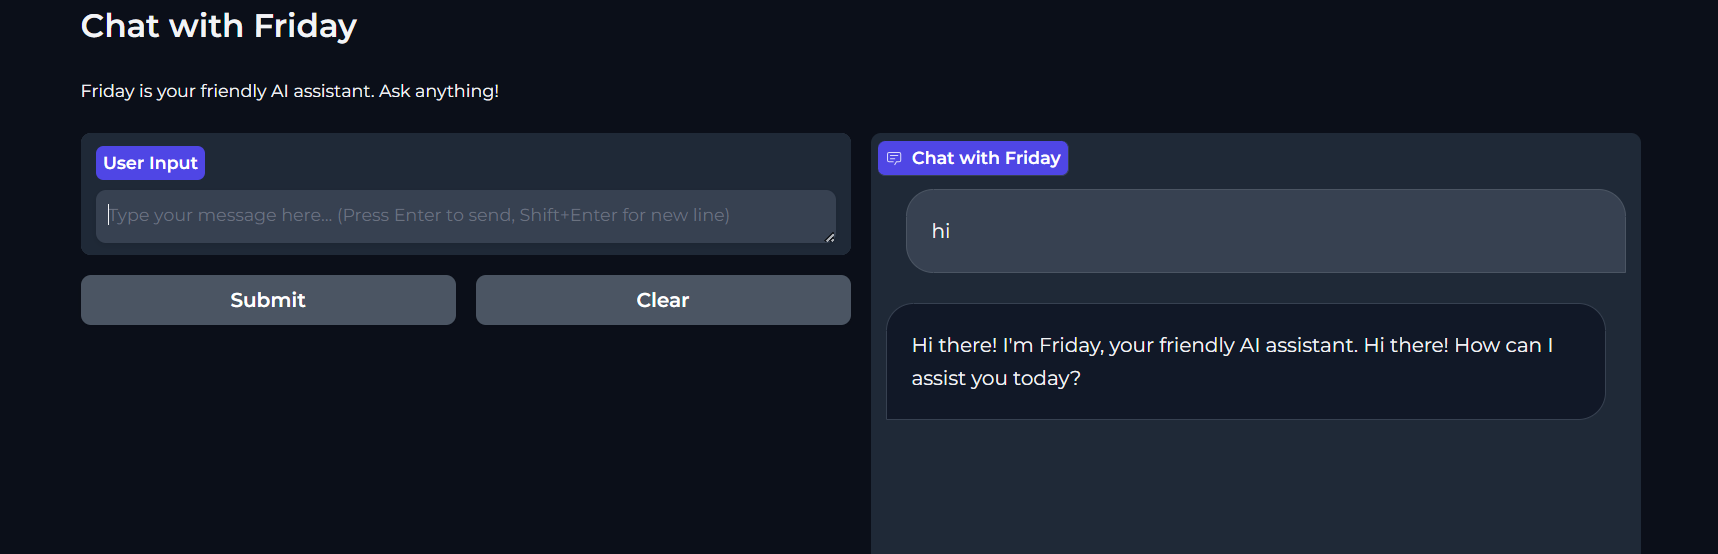
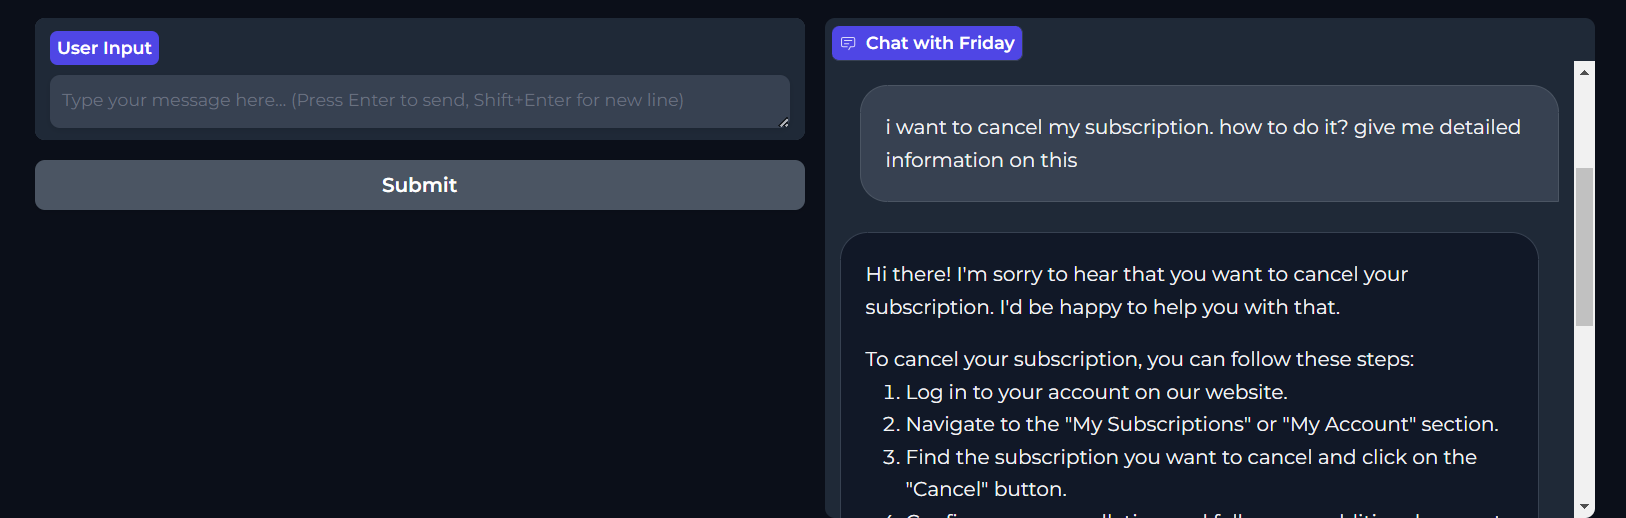
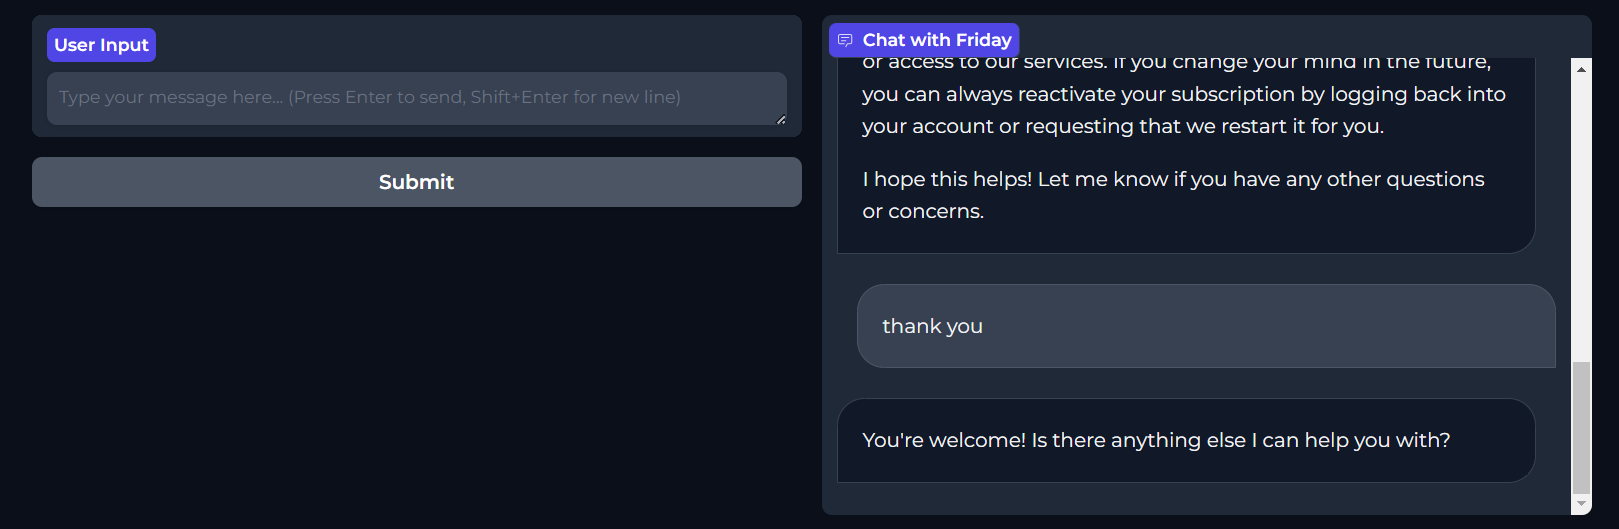


### for mobile chat view:

In [ ]:
import gradio as gr

def extract_friday_response(full_text):
    parts = full_text.split("### FRIDAY'S RESPONSE:")
    if len(parts) > 1:
        return parts[1].strip()
    else:
        return "I'm sorry, could you please elaborate?"

def is_farewell(user_input):
    farewells = ["bye", "goodbye", "see you", "farewell", "take care"]
    return any(word in user_input.lower() for word in farewells)

def chatbot_interface(user_input, history):
    if is_farewell(user_input):
        farewell_response = "I hope I helped you. Thank you for your time. Let me know if I can help you with anything else. Bye bye!"
        return "", history + [(user_input, farewell_response)], history + [(user_input, farewell_response)]

    response = rag_chain.invoke(user_input)
    full_text = response['text']
    friday_answer = extract_friday_response(full_text)

    is_first_interaction = len(history) == 0
    is_asking_identity = "who are you" in user_input.lower() or "what's your name" in user_input.lower()

    if is_first_interaction or is_asking_identity:
        introduction = "Hi there! I'm Friday, your friendly AI assistant. "
        friday_answer = introduction + friday_answer

    visible_history = history + [(user_input, friday_answer)]
    full_history = history + [(user_input, friday_answer)]

    return "", visible_history, full_history

# Create the Gradio interface
with gr.Blocks(theme="soft") as iface:
    gr.Markdown("# Chat with Friday")
    gr.Markdown("Friday is your friendly AI assistant. Ask anything!")

    chatbot = gr.Chatbot(label="Chat with Friday")
    msg = gr.Textbox(
        placeholder="Type your message here... (Press Enter to send, Shift+Enter for new line)",
        label="User Input",
        lines=1,
        max_lines=5
    )
    with gr.Row():
        submit = gr.Button("Submit")
        clear = gr.Button("Clear")

    state = gr.State([])

    # Define the submit action
    def on_submit(message, chat_history):
        return chatbot_interface(message, chat_history)

    # Connect the submit action to both the textbox and the submit button
    msg.submit(on_submit, inputs=[msg, state], outputs=[msg, chatbot, state])
    submit.click(on_submit, inputs=[msg, state], outputs=[msg, chatbot, state])

    # Clear button functionality
    clear.click(lambda: "", None, msg)
    clear.click(lambda: [], None, chatbot)
    clear.click(lambda: [], None, state)

# Launch the interface
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.48.0, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://4bd298c21595d491dc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
